In [1]:
import sys
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (12.0, 6.0)

In [2]:
import pandas as pd
import numpy as np

In [3]:
from agent import MABAgent
from agent import get_concept_drift
from agent import code_action

In [4]:
data = '../sarss.h5'

In [5]:
n_actions = 11 * 15

In [6]:
agent = MABAgent(n_actions=n_actions)

## get data

In [7]:
data_all = pd.read_hdf(data, key='sarss')
# process only traffic from both stations going to google
data = data_all[data_all['sites'] == ('google', 'google')]
columns_to_convert = ['new_channel', 'new_txpower', 'r']
# generates warning >> SettingWithCopyWarning
data.loc[:, columns_to_convert] = data.loc[:, columns_to_convert].astype('float')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [8]:
# define number of instances to use

n = data.shape[0]

In [9]:
data_to_use = data.iloc[:n, :]

In [10]:
drifts = get_concept_drift(data_to_use, n_train=40)  # get drift points from data
print("num drifts", len(drifts))

num drifts 141


In [24]:
nf = data_to_use['file_id'].unique().shape[0]
print("Average drifts per run: {:5.1f}".format(len(drifts) / nf))

Average drifts per run:   5.2


# MAB iterations

In [11]:
t = 1
T = 2
double_trick = True
__iterations = []

for __iter in range(n):
    __d = data_to_use.iloc[__iter, :]
    """
        a) get data from real execution, including the action performed --ea
        b) get action proposed by the algorithm -- a
        c) compare result: ea == a ?
        d) probability of selecting ea?
        e) concept drift? yes, mark this point
        f) update system using pa, so the system learns the real environment

    """
    new_channel = float(__d['new_channel'])
    new_txpower = float(__d['new_txpower'])

    a = agent.get_action()  # best action using the current knowledge
    ea = code_action(new_channel, new_txpower)  # action performed

    Pa = agent.prob_action(a) * 100
    Pea = agent.prob_action(ea) * 100

    r = __d['r']  # reward received
    drift = __iter in drifts
    print('{} t: {} ch{} pwr {} Estimated action: {}[P={}] Actual action: {}[P={}] Reward: {} Drift {}'.format(__iter, t, new_channel, new_txpower, ea, Pea, a, Pa, r, drift))

    __iterations.append([__iter, t, new_channel, new_txpower, ea, Pea, a, Pa, r, drift])
    # don't need to run_action
    # r, success = agent.run_action(a)
    agent.update(ea, r)  # update using the executed action in order to learn

    t += 1
    if double_trick and t > T:
        t = 1
        agent.reset_pulls()
        try:
            T = 2 * T
        except OverflowError:
            T = args.T

0 t: 1 ch2.0 pwr 8.0 Estimated action: 82[P=0.6060606060606061] Actual action: 0[P=0.6060606060606061] Reward: 5.0 Drift False
1 t: 2 ch2.0 pwr 8.0 Estimated action: 82[P=39.061642643208785] Actual action: 82[P=39.061642643208785] Reward: 4.5117215 Drift False
2 t: 1 ch2.0 pwr 8.0 Estimated action: 82[P=41.48367793631152] Actual action: 82[P=41.48367793631152] Reward: 4.56176425 Drift False
3 t: 2 ch2.0 pwr 8.0 Estimated action: 82[P=26.94510449271934] Actual action: 82[P=26.94510449271934] Reward: 4.56176425 Drift False
4 t: 3 ch2.0 pwr 8.0 Estimated action: 82[P=22.089620980078912] Actual action: 82[P=22.089620980078912] Reward: 4.56176425 Drift False
5 t: 4 ch2.0 pwr 8.0 Estimated action: 82[P=19.06495931634829] Actual action: 82[P=19.06495931634829] Reward: 3.820358 Drift False
6 t: 1 ch2.0 pwr 8.0 Estimated action: 82[P=35.50369744883907] Actual action: 82[P=35.50369744883907] Reward: 3.4367145 Drift False
7 t: 2 ch2.0 pwr 8.0 Estimated action: 82[P=18.087725041274368] Actual acti

247 t: 122 ch3.0 pwr 1.0 Estimated action: 13[P=2.9364812010773997] Actual action: 13[P=2.9364812010773997] Reward: 4.64237475 Drift False
248 t: 123 ch3.0 pwr 1.0 Estimated action: 13[P=2.930030984991496] Actual action: 13[P=2.930030984991496] Reward: 4.64237475 Drift False
249 t: 124 ch3.0 pwr 1.0 Estimated action: 13[P=2.923644844439545] Actual action: 13[P=2.923644844439545] Reward: 4.64237475 Drift False
250 t: 125 ch3.0 pwr 1.0 Estimated action: 13[P=2.9173216104915434] Actual action: 13[P=2.9173216104915434] Reward: 4.64237475 Drift False
251 t: 126 ch3.0 pwr 1.0 Estimated action: 13[P=2.9110601455511884] Actual action: 13[P=2.9110601455511884] Reward: 4.64237475 Drift False
252 t: 127 ch3.0 pwr 1.0 Estimated action: 13[P=2.904859342254007] Actual action: 13[P=2.904859342254007] Reward: 4.64237475 Drift False
253 t: 128 ch3.0 pwr 1.0 Estimated action: 13[P=2.898718122413331] Actual action: 13[P=2.898718122413331] Reward: 4.64237475 Drift False
254 t: 1 ch3.0 pwr 1.0 Estimated ac

441 t: 188 ch3.0 pwr 1.0 Estimated action: 13[P=2.575585646089381] Actual action: 13[P=2.575585646089381] Reward: 4.7133495 Drift False
442 t: 189 ch3.0 pwr 1.0 Estimated action: 13[P=2.572197960388129] Actual action: 13[P=2.572197960388129] Reward: 4.7133495 Drift False
443 t: 190 ch3.0 pwr 1.0 Estimated action: 13[P=2.5688332186625105] Actual action: 13[P=2.5688332186625105] Reward: 4.7133495 Drift False
444 t: 191 ch3.0 pwr 1.0 Estimated action: 13[P=2.565491133148622] Actual action: 13[P=2.565491133148622] Reward: 4.7133495 Drift False
445 t: 192 ch3.0 pwr 1.0 Estimated action: 13[P=2.562171421286651] Actual action: 13[P=2.562171421286651] Reward: 4.7133495 Drift False
446 t: 193 ch3.0 pwr 1.0 Estimated action: 13[P=2.558873805599296] Actual action: 13[P=2.558873805599296] Reward: 4.7133495 Drift False
447 t: 194 ch3.0 pwr 1.0 Estimated action: 13[P=2.5555980135738148] Actual action: 13[P=2.5555980135738148] Reward: 4.582910125 Drift False
448 t: 195 ch3.0 pwr 1.0 Estimated action:

624 t: 115 ch3.0 pwr 1.0 Estimated action: 13[P=2.9830957638281426] Actual action: 13[P=2.9830957638281426] Reward: 4.7133495 Drift False
625 t: 116 ch3.0 pwr 1.0 Estimated action: 13[P=2.9757387262569606] Actual action: 13[P=2.9757387262569606] Reward: 4.7133495 Drift False
626 t: 117 ch3.0 pwr 1.0 Estimated action: 13[P=2.9684692819493104] Actual action: 13[P=2.9684692819493104] Reward: 4.7133495 Drift False
627 t: 118 ch3.0 pwr 1.0 Estimated action: 13[P=2.9612856201230144] Actual action: 13[P=2.9612856201230144] Reward: 4.7133495 Drift False
628 t: 119 ch3.0 pwr 1.0 Estimated action: 13[P=2.9541859826384833] Actual action: 13[P=2.9541859826384833] Reward: 4.7133495 Drift False
629 t: 120 ch3.0 pwr 1.0 Estimated action: 13[P=2.9471686620357214] Actual action: 13[P=2.9471686620357214] Reward: 4.7252125 Drift False
630 t: 121 ch3.0 pwr 1.0 Estimated action: 13[P=2.940290169325213] Actual action: 13[P=2.940290169325213] Reward: 4.7252125 Drift False
631 t: 122 ch3.0 pwr 1.0 Estimated a

924 t: 415 ch3.0 pwr 1.0 Estimated action: 13[P=2.086383342002278] Actual action: 13[P=2.086383342002278] Reward: 4.51673825 Drift False
925 t: 416 ch3.0 pwr 1.0 Estimated action: 13[P=2.084649374750769] Actual action: 13[P=2.084649374750769] Reward: 4.51673825 Drift False
926 t: 417 ch3.0 pwr 1.0 Estimated action: 13[P=2.0829210546933776] Actual action: 13[P=2.0829210546933776] Reward: 4.51673825 Drift False
927 t: 418 ch3.0 pwr 1.0 Estimated action: 13[P=2.0811983507030396] Actual action: 13[P=2.0811983507030396] Reward: 4.51673825 Drift False
928 t: 419 ch3.0 pwr 1.0 Estimated action: 13[P=2.079481231896412] Actual action: 13[P=2.079481231896412] Reward: 4.51673825 Drift False
929 t: 420 ch3.0 pwr 1.0 Estimated action: 13[P=2.077769667631422] Actual action: 13[P=2.077769667631422] Reward: 4.51673825 Drift False
930 t: 421 ch3.0 pwr 1.0 Estimated action: 13[P=2.0760636275047797] Actual action: 13[P=2.0760636275047797] Reward: 4.51673825 Drift False
931 t: 422 ch3.0 pwr 1.0 Estimated 

1128 t: 107 ch1.0 pwr 5.0 Estimated action: 51[P=3.556720152804603] Actual action: 51[P=3.556720152804603] Reward: 4.70259225 Drift False
1129 t: 108 ch1.0 pwr 5.0 Estimated action: 51[P=3.5461566893549588] Actual action: 51[P=3.5461566893549588] Reward: 4.70259225 Drift False
1130 t: 109 ch1.0 pwr 5.0 Estimated action: 51[P=3.5357079716737934] Actual action: 51[P=3.5357079716737934] Reward: 4.70259225 Drift False
1131 t: 110 ch1.0 pwr 5.0 Estimated action: 51[P=3.5253721325338625] Actual action: 51[P=3.5253721325338625] Reward: 4.70259225 Drift False
1132 t: 111 ch1.0 pwr 5.0 Estimated action: 51[P=3.515147337381757] Actual action: 51[P=3.515147337381757] Reward: 4.70259225 Drift False
1133 t: 112 ch1.0 pwr 5.0 Estimated action: 51[P=3.505031784208496] Actual action: 51[P=3.505031784208496] Reward: 4.70259225 Drift False
1134 t: 113 ch1.0 pwr 5.0 Estimated action: 51[P=3.4950237033617104] Actual action: 51[P=3.4950237033617104] Reward: 4.70259225 Drift False
1135 t: 114 ch1.0 pwr 5.0 

1334 t: 313 ch1.0 pwr 5.0 Estimated action: 51[P=2.448859618888024] Actual action: 51[P=2.448859618888024] Reward: 4.70259225 Drift False
1335 t: 314 ch1.0 pwr 5.0 Estimated action: 51[P=2.446500840177407] Actual action: 51[P=2.446500840177407] Reward: 4.70259225 Drift False
1336 t: 315 ch1.0 pwr 5.0 Estimated action: 51[P=2.444151677998004] Actual action: 51[P=2.444151677998004] Reward: 4.70259225 Drift False
1337 t: 316 ch1.0 pwr 5.0 Estimated action: 51[P=2.4418120665951384] Actual action: 51[P=2.4418120665951384] Reward: 4.70259225 Drift False
1338 t: 317 ch1.0 pwr 5.0 Estimated action: 51[P=2.439481940831992] Actual action: 51[P=2.439481940831992] Reward: 4.70259225 Drift False
1339 t: 318 ch1.0 pwr 5.0 Estimated action: 51[P=2.4371612361823223] Actual action: 51[P=2.4371612361823223] Reward: 4.70259225 Drift False
1340 t: 319 ch1.0 pwr 5.0 Estimated action: 51[P=2.4348498887233325] Actual action: 51[P=2.4348498887233325] Reward: 4.70259225 Drift False
1341 t: 320 ch1.0 pwr 5.0 Es

1515 t: 494 ch8.0 pwr 1.0 Estimated action: 18[P=2.181415912861394] Actual action: 18[P=2.181415912861394] Reward: 4.551651875 Drift False
1516 t: 495 ch8.0 pwr 1.0 Estimated action: 18[P=2.1773159622178406] Actual action: 18[P=2.1773159622178406] Reward: 4.551651875 Drift False
1517 t: 496 ch8.0 pwr 1.0 Estimated action: 18[P=2.1732669661127684] Actual action: 18[P=2.1732669661127684] Reward: 4.551651875 Drift False
1518 t: 497 ch8.0 pwr 1.0 Estimated action: 18[P=2.169267754718927] Actual action: 18[P=2.169267754718927] Reward: 4.399005 Drift False
1519 t: 498 ch8.0 pwr 1.0 Estimated action: 18[P=2.161424572629035] Actual action: 18[P=2.161424572629035] Reward: 4.399005 Drift False
1520 t: 499 ch8.0 pwr 1.0 Estimated action: 18[P=2.153741773608069] Actual action: 18[P=2.153741773608069] Reward: 4.399005 Drift False
1521 t: 500 ch8.0 pwr 1.0 Estimated action: 18[P=2.1462137994090464] Actual action: 18[P=2.1462137994090464] Reward: 4.399005 Drift False
1522 t: 501 ch8.0 pwr 1.0 Estimat

1704 t: 683 ch5.0 pwr 8.0 Estimated action: 85[P=2.18021784579939] Actual action: 85[P=2.18021784579939] Reward: 4.772949125 Drift False
1705 t: 684 ch5.0 pwr 8.0 Estimated action: 85[P=2.1787979634219274] Actual action: 85[P=2.1787979634219274] Reward: 4.772949125 Drift False
1706 t: 685 ch5.0 pwr 8.0 Estimated action: 85[P=2.1773827805155577] Actual action: 85[P=2.1773827805155577] Reward: 4.772949125 Drift False
1707 t: 686 ch5.0 pwr 8.0 Estimated action: 85[P=2.1759722792119103] Actual action: 85[P=2.1759722792119103] Reward: 4.772949125 Drift False
1708 t: 687 ch5.0 pwr 8.0 Estimated action: 85[P=2.174566441347914] Actual action: 85[P=2.174566441347914] Reward: 4.704276375 Drift False
1709 t: 688 ch5.0 pwr 8.0 Estimated action: 85[P=2.1723632280534337] Actual action: 85[P=2.1723632280534337] Reward: 4.704276375 Drift False
1710 t: 689 ch5.0 pwr 8.0 Estimated action: 85[P=2.1701746932829438] Actual action: 85[P=2.1701746932829438] Reward: 4.704276375 Drift False
1711 t: 690 ch5.0 p

1921 t: 900 ch5.0 pwr 8.0 Estimated action: 85[P=1.9056478314968612] Actual action: 85[P=1.9056478314968612] Reward: 4.767884375 Drift False
1922 t: 901 ch5.0 pwr 8.0 Estimated action: 85[P=1.9049685906388885] Actual action: 85[P=1.9049685906388885] Reward: 4.767884375 Drift False
1923 t: 902 ch5.0 pwr 8.0 Estimated action: 85[P=1.904290453372987] Actual action: 85[P=1.904290453372987] Reward: 4.767884375 Drift False
1924 t: 903 ch5.0 pwr 8.0 Estimated action: 85[P=1.9036134173514925] Actual action: 85[P=1.9036134173514925] Reward: 4.767884375 Drift False
1925 t: 904 ch5.0 pwr 8.0 Estimated action: 85[P=1.9029374802226031] Actual action: 85[P=1.9029374802226031] Reward: 4.767884375 Drift False
1926 t: 905 ch5.0 pwr 8.0 Estimated action: 85[P=1.9022626396305413] Actual action: 85[P=1.9022626396305413] Reward: 4.767884375 Drift False
1927 t: 906 ch5.0 pwr 8.0 Estimated action: 85[P=1.9015888932158491] Actual action: 85[P=1.9015888932158491] Reward: 4.767884375 Drift False
1928 t: 907 ch5

2143 t: 98 ch3.0 pwr 8.0 Estimated action: 83[P=1.0897766684698822] Actual action: 78[P=7.754049870428202] Reward: 4.72428575 Drift False
2144 t: 99 ch3.0 pwr 8.0 Estimated action: 83[P=1.0868326055710493] Actual action: 78[P=7.753136789294601] Reward: 4.72428575 Drift False
2145 t: 100 ch3.0 pwr 8.0 Estimated action: 83[P=1.0839251359133317] Actual action: 78[P=7.752230548296521] Reward: 4.72428575 Drift False
2146 t: 101 ch3.0 pwr 8.0 Estimated action: 83[P=1.0810534566420034] Actual action: 78[P=7.751331044584893] Reward: 4.72428575 Drift False
2147 t: 102 ch3.0 pwr 8.0 Estimated action: 83[P=1.0782167903357862] Actual action: 78[P=7.750438177526959] Reward: 4.72428575 Drift False
2148 t: 103 ch3.0 pwr 8.0 Estimated action: 83[P=1.0754143839529373] Actual action: 78[P=7.749551848648528] Reward: 4.72428575 Drift False
2149 t: 104 ch3.0 pwr 8.0 Estimated action: 83[P=1.072645507831163] Actual action: 78[P=7.748671961577866] Reward: 4.72428575 Drift False
2150 t: 105 ch3.0 pwr 8.0 Esti

2367 t: 322 ch4.0 pwr 8.0 Estimated action: 84[P=0.23774568588383446] Actual action: 78[P=2.0980193902668836] Reward: 4.748580125 Drift False
2368 t: 323 ch4.0 pwr 8.0 Estimated action: 84[P=0.2379779298527594] Actual action: 78[P=2.0980115397504773] Reward: 4.748580125 Drift False
2369 t: 324 ch4.0 pwr 8.0 Estimated action: 84[P=0.23817091218427525] Actual action: 78[P=2.098004507135815] Reward: 4.7726525 Drift False
2370 t: 325 ch4.0 pwr 8.0 Estimated action: 84[P=0.23846787602034006] Actual action: 78[P=2.0979952801189077] Reward: 4.7726525 Drift False
2371 t: 326 ch4.0 pwr 8.0 Estimated action: 84[P=0.23872598597270614] Actual action: 78[P=2.0979868626636407] Reward: 4.7726525 Drift False
2372 t: 327 ch4.0 pwr 8.0 Estimated action: 84[P=0.23894854034081817] Actual action: 78[P=2.097979185517538] Reward: 4.7726525 Drift False
2373 t: 328 ch4.0 pwr 8.0 Estimated action: 84[P=0.23913851736240177] Actual action: 78[P=2.0979721861578424] Reward: 4.7726525 Drift False
2374 t: 329 ch4.0 p

2573 t: 528 ch5.0 pwr 5.0 Estimated action: 55[P=0.21782059897265843] Actual action: 78[P=2.0557121599228143] Reward: 4.717764 Drift False
2574 t: 529 ch5.0 pwr 5.0 Estimated action: 55[P=0.21753806817667454] Actual action: 78[P=2.055716452088048] Reward: 4.717764 Drift False
2575 t: 530 ch5.0 pwr 5.0 Estimated action: 55[P=0.2172581536086991] Actual action: 78[P=2.05572068738721] Reward: 4.717764 Drift False
2576 t: 531 ch5.0 pwr 5.0 Estimated action: 55[P=0.21698080934706981] Actual action: 78[P=2.055724866792013] Reward: 4.717764 Drift False
2577 t: 532 ch5.0 pwr 5.0 Estimated action: 55[P=0.21670599062453633] Actual action: 78[P=2.055728991250213] Reward: 4.717764 Drift False
2578 t: 533 ch5.0 pwr 5.0 Estimated action: 55[P=0.21643365379103596] Actual action: 78[P=2.0557330616863183] Reward: 4.717764 Drift False
2579 t: 534 ch5.0 pwr 5.0 Estimated action: 55[P=0.21616375627792742] Actual action: 78[P=2.055737079002361] Reward: 4.717764 Drift False
2580 t: 535 ch5.0 pwr 5.0 Estimate

2846 t: 801 ch2.0 pwr 9.0 Estimated action: 92[P=0.14581168529077115] Actual action: 52[P=1.60117899080565] Reward: 4.55405825 Drift False
2847 t: 802 ch5.0 pwr 5.0 Estimated action: 55[P=0.14519632385216974] Actual action: 52[P=1.6011857795448206] Reward: 4.55405825 Drift False
2848 t: 803 ch2.0 pwr 9.0 Estimated action: 92[P=0.1454938953248358] Actual action: 52[P=1.6011918310497075] Reward: 4.55405825 Drift False
2849 t: 804 ch5.0 pwr 5.0 Estimated action: 55[P=0.1449236009336557] Actual action: 52[P=1.6011985519552976] Reward: 4.55405825 Drift False
2850 t: 805 ch5.0 pwr 5.0 Estimated action: 55[P=0.14468401215657856] Actual action: 52[P=1.6012045541870448] Reward: 4.55405825 Drift False
2851 t: 806 ch5.0 pwr 5.0 Estimated action: 55[P=0.1444467864971239] Actual action: 52[P=1.6012105141508681] Reward: 4.55405825 Drift False
2852 t: 807 ch2.0 pwr 9.0 Estimated action: 92[P=0.14511946143676369] Actual action: 52[P=1.6012164324841525] Reward: 4.55405825 Drift False
2853 t: 808 ch5.0 

3027 t: 982 ch1.0 pwr 8.0 Estimated action: 81[P=0.13199595520311086] Actual action: 52[P=1.6205194046521147] Reward: 4.554647625 Drift False
3028 t: 983 ch1.0 pwr 8.0 Estimated action: 81[P=0.13180579140008936] Actual action: 52[P=1.6205244566086883] Reward: 4.597153 Drift False
3029 t: 984 ch1.0 pwr 8.0 Estimated action: 81[P=0.13165767293241123] Actual action: 52[P=1.6205288231207902] Reward: 4.597153 Drift False
3030 t: 985 ch1.0 pwr 8.0 Estimated action: 81[P=0.13151097805073525] Actual action: 52[P=1.6205331633497664] Reward: 4.597153 Drift False
3031 t: 986 ch1.0 pwr 8.0 Estimated action: 81[P=0.1313656818072451] Actual action: 52[P=1.6205374777083705] Reward: 4.597153 Drift False
3032 t: 987 ch1.0 pwr 8.0 Estimated action: 81[P=0.1312217598665605] Actual action: 52[P=1.6205417665993915] Reward: 4.597153 Drift False
3033 t: 988 ch1.0 pwr 8.0 Estimated action: 81[P=0.1310791884865917] Actual action: 52[P=1.620546030415964] Reward: 4.597153 Drift False
3034 t: 989 ch1.0 pwr 8.0 Es

3237 t: 1192 ch1.0 pwr 8.0 Estimated action: 81[P=0.11398840335706288] Actual action: 52[P=1.6211648100714189] Reward: 4.59878425 Drift False
3238 t: 1193 ch1.0 pwr 8.0 Estimated action: 81[P=0.11394587407933228] Actual action: 52[P=1.62116693753405] Reward: 4.59878425 Drift False
3239 t: 1194 ch1.0 pwr 8.0 Estimated action: 81[P=0.11390347318654678] Actual action: 52[P=1.6211690609399438] Reward: 4.59878425 Drift False
3240 t: 1195 ch1.0 pwr 8.0 Estimated action: 81[P=0.11386119988462311] Actual action: 52[P=1.6211711803061108] Reward: 4.59878425 Drift False
3241 t: 1196 ch1.0 pwr 8.0 Estimated action: 81[P=0.11381905338680434] Actual action: 52[P=1.621173295649416] Reward: 4.59878425 Drift False
3242 t: 1197 ch1.0 pwr 8.0 Estimated action: 81[P=0.11377703291357305] Actual action: 52[P=1.6211754069866258] Reward: 4.59878425 Drift False
3243 t: 1198 ch1.0 pwr 8.0 Estimated action: 81[P=0.11373513769256231] Actual action: 52[P=1.6211775143343508] Reward: 4.59878425 Drift False
3244 t: 1

3418 t: 1373 ch1.0 pwr 8.0 Estimated action: 81[P=0.10829631072721427] Actual action: 52[P=1.6214887371710889] Reward: 4.596076125 Drift False
3419 t: 1374 ch1.0 pwr 8.0 Estimated action: 81[P=0.10826715501220825] Actual action: 52[P=1.6214903476767546] Reward: 4.596076125 Drift False
3420 t: 1375 ch1.0 pwr 8.0 Estimated action: 81[P=0.10823805843228422] Actual action: 52[P=1.6214919558373948] Reward: 4.209242625 Drift False
3421 t: 1376 ch1.0 pwr 8.0 Estimated action: 81[P=0.10813045229620932] Actual action: 52[P=1.6214948370218762] Reward: 4.145717 Drift False
3422 t: 1377 ch1.0 pwr 8.0 Estimated action: 81[P=0.10801043814329349] Actual action: 52[P=1.6214979182413631] Reward: 4.145717 Drift False
3423 t: 1378 ch1.0 pwr 8.0 Estimated action: 81[P=0.10789094809618678] Actual action: 52[P=1.6215009895778116] Reward: 4.145717 Drift False
3424 t: 1379 ch1.0 pwr 8.0 Estimated action: 81[P=0.1077719786074342] Actual action: 52[P=1.6215040510912886] Reward: 4.596076125 Drift False
3425 t: 1

3613 t: 1568 ch1.0 pwr 8.0 Estimated action: 81[P=0.10321367248182696] Actual action: 52[P=1.6217695489974187] Reward: 4.598146625 Drift False
3614 t: 1569 ch1.0 pwr 8.0 Estimated action: 81[P=0.1031935039974287] Actual action: 52[P=1.6217707846452263] Reward: 4.598146625 Drift False
3615 t: 1570 ch1.0 pwr 8.0 Estimated action: 81[P=0.10317336342011603] Actual action: 52[P=1.6217720188485423] Reward: 4.598146625 Drift False
3616 t: 1571 ch1.0 pwr 8.0 Estimated action: 81[P=0.10315325067236081] Actual action: 52[P=1.6217732516102195] Reward: 4.598146625 Drift False
3617 t: 1572 ch1.0 pwr 8.0 Estimated action: 81[P=0.1031331656769662] Actual action: 52[P=1.6217744829330965] Reward: 4.598146625 Drift False
3618 t: 1573 ch1.0 pwr 8.0 Estimated action: 81[P=0.10311310835706688] Actual action: 52[P=1.6217757128200214] Reward: 4.598146625 Drift False
3619 t: 1574 ch1.0 pwr 8.0 Estimated action: 81[P=0.10309307863612485] Actual action: 52[P=1.6217769412738194] Reward: 4.598146625 Drift False
3

3835 t: 1790 ch1.0 pwr 8.0 Estimated action: 81[P=0.09919241287108202] Actual action: 52[P=1.6220146971137352] Reward: 4.596076125 Drift False
3836 t: 1791 ch1.0 pwr 8.0 Estimated action: 81[P=0.09917691446342787] Actual action: 52[P=1.6220156704859947] Reward: 4.596076125 Drift False
3837 t: 1792 ch6.0 pwr 12.0 Estimated action: 126[P=1.3610738262985629] Actual action: 52[P=1.6220166428801173] Reward: 4.596076125 Drift False
3838 t: 1793 ch6.0 pwr 12.0 Estimated action: 126[P=0.8275100660163508] Actual action: 52[P=1.6307914481802348] Reward: 4.595535375 Drift False
3839 t: 1794 ch6.0 pwr 12.0 Estimated action: 126[P=0.614434564650859] Actual action: 52[P=1.634296153596345] Reward: 4.600154 Drift True
3840 t: 1795 ch6.0 pwr 12.0 Estimated action: 126[P=0.5019016157649265] Actual action: 52[P=1.6361475394623157] Reward: 4.55144075 Drift False
3841 t: 1796 ch6.0 pwr 12.0 Estimated action: 126[P=0.4279846779769151] Actual action: 52[P=1.6373639241722426] Reward: 4.5528075 Drift False
384

4061 t: 2016 ch1.0 pwr 3.0 Estimated action: 31[P=0.16988890718892577] Actual action: 52[P=1.6619344237531701] Reward: 4.587600125 Drift False
4062 t: 2017 ch1.0 pwr 3.0 Estimated action: 31[P=0.1682815102882387] Actual action: 52[P=1.661962239288143] Reward: 4.587600125 Drift False
4063 t: 2018 ch1.0 pwr 3.0 Estimated action: 31[P=0.16675480313093358] Actual action: 52[P=1.6619887107476898] Reward: 4.587600125 Drift False
4064 t: 2019 ch1.0 pwr 3.0 Estimated action: 31[P=0.16530246847455365] Actual action: 52[P=1.6620139432974974] Reward: 4.587600125 Drift False
4065 t: 2020 ch1.0 pwr 3.0 Estimated action: 31[P=0.16391884657542194] Actual action: 52[P=1.662038031157708] Reward: 4.587600125 Drift False
4066 t: 2021 ch1.0 pwr 3.0 Estimated action: 31[P=0.16259885088565865] Actual action: 52[P=1.6620610590063034] Reward: 4.587600125 Drift False
4067 t: 2022 ch1.0 pwr 3.0 Estimated action: 31[P=0.16133789647489208] Actual action: 52[P=1.6620831031707362] Reward: 4.587600125 Drift False
40

4344 t: 251 ch5.0 pwr 1.0 Estimated action: 15[P=0.19510123261468293] Actual action: 52[P=1.6993887984071174] Reward: 4.6092805 Drift False
4345 t: 252 ch5.0 pwr 1.0 Estimated action: 15[P=0.19513195932606497] Actual action: 52[P=1.6994167879147335] Reward: 4.6092805 Drift False
4346 t: 253 ch5.0 pwr 1.0 Estimated action: 15[P=0.19507648645338066] Actual action: 52[P=1.6994460902340955] Reward: 4.6092805 Drift False
4347 t: 254 ch5.0 pwr 1.0 Estimated action: 15[P=0.19495024131221694] Actual action: 52[P=1.6994764441888965] Reward: 4.6092805 Drift False
4348 t: 255 ch5.0 pwr 1.0 Estimated action: 15[P=0.19476578721660953] Actual action: 52[P=1.6995076373344526] Reward: 4.5452515 Drift False
4349 t: 256 ch5.0 pwr 1.0 Estimated action: 15[P=0.19405586211669207] Actual action: 52[P=1.699547627908921] Reward: 4.438875 Drift False
4350 t: 257 ch5.0 pwr 1.0 Estimated action: 15[P=0.1925853956579938] Actual action: 52[P=1.6996004207054094] Reward: 4.438875 Drift False
4351 t: 258 ch5.0 pwr 1.

4624 t: 531 ch9.0 pwr 14.0 Estimated action: 149[P=0.1607595820146273] Actual action: 52[P=1.7719193891605194] Reward: 4.44188725 Drift False
4625 t: 532 ch9.0 pwr 14.0 Estimated action: 149[P=0.1601727784787008] Actual action: 52[P=1.7719443307029217] Reward: 4.44188725 Drift False
4626 t: 533 ch9.0 pwr 14.0 Estimated action: 149[P=0.15960035765083344] Actual action: 52[P=1.7719689805487955] Reward: 4.44188725 Drift False
4627 t: 534 ch9.0 pwr 14.0 Estimated action: 149[P=0.15904172202862696] Actual action: 52[P=1.7719933494559814] Reward: 4.44188725 Drift False
4628 t: 535 ch9.0 pwr 14.0 Estimated action: 149[P=0.15849630803432813] Actual action: 52[P=1.7720174475795742] Reward: 4.44188725 Drift False
4629 t: 536 ch9.0 pwr 14.0 Estimated action: 149[P=0.15796358359749366] Actual action: 52[P=1.7720412845148443] Reward: 4.44188725 Drift False
4630 t: 537 ch9.0 pwr 14.0 Estimated action: 149[P=0.1574430459436154] Actual action: 52[P=1.772064869336447] Reward: 4.44188725 Drift False
463

4793 t: 700 ch6.0 pwr 6.0 Estimated action: 66[P=0.175355317883103] Actual action: 52[P=1.8234357245468094] Reward: 4.706062875 Drift False
4794 t: 701 ch6.0 pwr 6.0 Estimated action: 66[P=0.17515508185213738] Actual action: 52[P=1.823458289723159] Reward: 4.706062875 Drift False
4795 t: 702 ch6.0 pwr 6.0 Estimated action: 66[P=0.17495662555444086] Actual action: 52[P=1.8234807891734002] Reward: 4.65491325 Drift False
4796 t: 703 ch6.0 pwr 6.0 Estimated action: 66[P=0.17470122356456683] Actual action: 52[P=1.823504295737379] Reward: 4.65491325 Drift False
4797 t: 704 ch6.0 pwr 6.0 Estimated action: 66[P=0.1744484595135758] Actual action: 52[P=1.8235277211301575] Reward: 4.65491325 Drift False
4798 t: 705 ch6.0 pwr 6.0 Estimated action: 66[P=0.1741982853260905] Actual action: 52[P=1.8235510663335508] Reward: 4.706062875 Drift False
4799 t: 706 ch6.0 pwr 6.0 Estimated action: 66[P=0.17400796700527008] Actual action: 52[P=1.8235732853428614] Reward: 4.706062875 Drift False
4800 t: 707 ch6

4934 t: 841 ch4.0 pwr 5.0 Estimated action: 54[P=1.4554993411076875] Actual action: 52[P=1.8262042939709309] Reward: 3.12366775 Drift False
4935 t: 842 ch11.0 pwr 3.0 Estimated action: 41[P=0.04570674934253681] Actual action: 52[P=1.844882460151063] Reward: 4.55611275 Drift False
4936 t: 843 ch6.0 pwr 15.0 Estimated action: 156[P=0.04506278287654925] Actual action: 52[P=1.8187174816528686] Reward: 4.5142805 Drift False
4937 t: 844 ch2.0 pwr 13.0 Estimated action: 132[P=1.5013346237480734] Actual action: 52[P=1.7943457336023747] Reward: 4.5142805 Drift False
4938 t: 845 ch10.0 pwr 13.0 Estimated action: 140[P=0.044738691337529155] Actual action: 52[P=1.8052959143770289] Reward: 4.5142805 Drift False
4939 t: 846 ch10.0 pwr 14.0 Estimated action: 150[P=1.4904033339079419] Actual action: 52[P=1.781281015732588] Reward: 4.534095 Drift False
4940 t: 847 ch2.0 pwr 14.0 Estimated action: 142[P=0.04441544461905474] Actual action: 52[P=1.791914300749817] Reward: 4.534095 Drift False
4941 t: 848 

5073 t: 980 ch2.0 pwr 5.0 Estimated action: 52[P=0.15232443115108235] Actual action: 135[P=1.7843378725232026] Reward: 4.735365625 Drift False
5074 t: 981 ch2.0 pwr 5.0 Estimated action: 52[P=0.15226351082388123] Actual action: 135[P=1.7843531079347192] Reward: 4.735365625 Drift False
5075 t: 982 ch2.0 pwr 5.0 Estimated action: 52[P=0.15220247011408564] Actual action: 135[P=1.7843683280531653] Reward: 4.735365625 Drift False
5076 t: 983 ch2.0 pwr 5.0 Estimated action: 52[P=0.1521413203496357] Actual action: 135[P=1.7843835327155766] Reward: 4.735365625 Drift False
5077 t: 984 ch2.0 pwr 5.0 Estimated action: 52[P=0.15208007237761453] Actual action: 135[P=1.7843987217674624] Reward: 4.735365625 Drift False
5078 t: 985 ch2.0 pwr 5.0 Estimated action: 52[P=0.15201873658534973] Actual action: 135[P=1.7844138950624047] Reward: 4.735365625 Drift False
5079 t: 986 ch2.0 pwr 5.0 Estimated action: 52[P=0.1519573229204922] Actual action: 135[P=1.7844290524617077] Reward: 4.735365625 Drift False
5

5268 t: 1175 ch2.0 pwr 9.0 Estimated action: 92[P=0.13374862501725088] Actual action: 135[P=1.8409552008385506] Reward: 4.748580125 Drift False
5269 t: 1176 ch2.0 pwr 9.0 Estimated action: 92[P=0.1337560411310735] Actual action: 135[P=1.8409682019747737] Reward: 4.748580125 Drift False
5270 t: 1177 ch2.0 pwr 9.0 Estimated action: 92[P=0.1337632055988195] Actual action: 135[P=1.8409811943724839] Reward: 4.7726525 Drift False
5271 t: 1178 ch2.0 pwr 9.0 Estimated action: 92[P=0.13378102316792215] Actual action: 135[P=1.8409939770321804] Reward: 4.7726525 Drift False
5272 t: 1179 ch2.0 pwr 9.0 Estimated action: 92[P=0.13379852353524913] Actual action: 135[P=1.8410067522092832] Reward: 4.7726525 Drift False
5273 t: 1180 ch2.0 pwr 9.0 Estimated action: 92[P=0.13381571036385984] Actual action: 135[P=1.8410195198613348] Reward: 4.7726525 Drift False
5274 t: 1181 ch2.0 pwr 9.0 Estimated action: 92[P=0.13383258726632827] Actual action: 135[P=1.841032279946725] Reward: 4.7726525 Drift False
5275 

5474 t: 1381 ch2.0 pwr 9.0 Estimated action: 92[P=0.1327117254970554] Actual action: 135[P=1.8434299552622977] Reward: 4.7726525 Drift False
5475 t: 1382 ch2.0 pwr 9.0 Estimated action: 92[P=0.13270517188010567] Actual action: 135[P=1.8434409051500444] Reward: 4.7726525 Drift False
5476 t: 1383 ch2.0 pwr 9.0 Estimated action: 92[P=0.13269856839709834] Actual action: 135[P=1.8434518465912115] Reward: 4.7726525 Drift False
5477 t: 1384 ch2.0 pwr 9.0 Estimated action: 92[P=0.13269191547820436] Actual action: 135[P=1.843462779592792] Reward: 4.7726525 Drift False
5478 t: 1385 ch2.0 pwr 9.0 Estimated action: 92[P=0.13268521354976676] Actual action: 135[P=1.8434737041618323] Reward: 4.7726525 Drift False
5479 t: 1386 ch2.0 pwr 9.0 Estimated action: 92[P=0.13267846303434025] Actual action: 135[P=1.8434846203053998] Reward: 4.7726525 Drift False
5480 t: 1387 ch2.0 pwr 9.0 Estimated action: 92[P=0.13267166435073072] Actual action: 135[P=1.8434955280306098] Reward: 4.7726525 Drift False
5481 t: 

5616 t: 1523 ch2.0 pwr 9.0 Estimated action: 92[P=0.13079557120771015] Actual action: 135[P=1.8449157270586343] Reward: 4.7726525 Drift False
5617 t: 1524 ch2.0 pwr 9.0 Estimated action: 92[P=0.1307859824545465] Actual action: 135[P=1.8449255378007674] Reward: 4.7726525 Drift False
5618 t: 1525 ch2.0 pwr 9.0 Estimated action: 92[P=0.13077637636088052] Actual action: 135[P=1.8449353413132772] Reward: 4.7726525 Drift False
5619 t: 1526 ch2.0 pwr 9.0 Estimated action: 92[P=0.1307667530756004] Actual action: 135[P=1.8449451376043184] Reward: 4.7726525 Drift False
5620 t: 1527 ch2.0 pwr 9.0 Estimated action: 92[P=0.1307571127464978] Actual action: 135[P=1.8449549266820533] Reward: 4.7726525 Drift False
5621 t: 1528 ch2.0 pwr 9.0 Estimated action: 92[P=0.1307474555202761] Actual action: 135[P=1.8449647085546355] Reward: 4.7726525 Drift False
5622 t: 1529 ch2.0 pwr 9.0 Estimated action: 92[P=0.1307377815425587] Actual action: 135[P=1.8449744832302082] Reward: 4.7726525 Drift False
5623 t: 153

5796 t: 1703 ch2.0 pwr 9.0 Estimated action: 92[P=0.12771902103848753] Actual action: 135[P=1.8465945418804572] Reward: 4.7726525 Drift False
5797 t: 1704 ch2.0 pwr 9.0 Estimated action: 92[P=0.12770947717573738] Actual action: 135[P=1.846603149066433] Reward: 4.7726525 Drift False
5798 t: 1705 ch2.0 pwr 9.0 Estimated action: 92[P=0.12769992748021392] Actual action: 135[P=1.8466117504562258] Reward: 4.7726525 Drift False
5799 t: 1706 ch2.0 pwr 9.0 Estimated action: 92[P=0.1276903720076989] Actual action: 135[P=1.8466203460564352] Reward: 4.7726525 Drift False
5800 t: 1707 ch2.0 pwr 9.0 Estimated action: 92[P=0.12768081081363178] Actual action: 135[P=1.8466289358736474] Reward: 4.7726525 Drift False
5801 t: 1708 ch2.0 pwr 9.0 Estimated action: 92[P=0.12767124395311177] Actual action: 135[P=1.8466375199144285] Reward: 4.7726525 Drift False
5802 t: 1709 ch2.0 pwr 9.0 Estimated action: 92[P=0.1276616714809017] Actual action: 135[P=1.8466460981853536] Reward: 4.7726525 Drift False
5803 t: 1

6036 t: 1943 ch2.0 pwr 9.0 Estimated action: 92[P=0.1242415315524104] Actual action: 135[P=1.8485285205510387] Reward: 4.7726525 Drift False
6037 t: 1944 ch2.0 pwr 9.0 Estimated action: 92[P=0.12423276557207323] Actual action: 135[P=1.848535886638188] Reward: 4.7726525 Drift False
6038 t: 1945 ch2.0 pwr 9.0 Estimated action: 92[P=0.12422399874780873] Actual action: 135[P=1.848543248323265] Reward: 4.7726525 Drift False
6039 t: 1946 ch2.0 pwr 9.0 Estimated action: 92[P=0.12421523109888968] Actual action: 135[P=1.848550605610913] Reward: 4.7726525 Drift False
6040 t: 1947 ch2.0 pwr 9.0 Estimated action: 92[P=0.12420646264448869] Actual action: 135[P=1.848557958505768] Reward: 4.7726525 Drift False
6041 t: 1948 ch2.0 pwr 9.0 Estimated action: 92[P=0.12419769340367716] Actual action: 135[P=1.8485653070124504] Reward: 4.7726525 Drift False
6042 t: 1949 ch2.0 pwr 9.0 Estimated action: 92[P=0.12418892339542784] Actual action: 135[P=1.848572651135585] Reward: 4.7726525 Drift False
6043 t: 1950

6246 t: 2153 ch2.0 pwr 9.0 Estimated action: 92[P=0.12192134123168534] Actual action: 135[P=1.8499943379462713] Reward: 4.7726525 Drift False
6247 t: 2154 ch2.0 pwr 9.0 Estimated action: 92[P=0.12191311555046572] Actual action: 135[P=1.8500008647247383] Reward: 4.7726525 Drift False
6248 t: 2155 ch2.0 pwr 9.0 Estimated action: 92[P=0.12190489082893026] Actual action: 135[P=1.8500073879600343] Reward: 4.7726525 Drift False
6249 t: 2156 ch2.0 pwr 9.0 Estimated action: 92[P=0.1218966670749407] Actual action: 135[P=1.8500139076556164] Reward: 4.7726525 Drift False
6250 t: 2157 ch2.0 pwr 9.0 Estimated action: 92[P=0.12188844429631877] Actual action: 135[P=1.8500204238149236] Reward: 4.7726525 Drift False
6251 t: 2158 ch2.0 pwr 9.0 Estimated action: 92[P=0.12188022250084801] Actual action: 135[P=1.850026936441405] Reward: 4.7726525 Drift False
6252 t: 2159 ch2.0 pwr 9.0 Estimated action: 92[P=0.12187200169627146] Actual action: 135[P=1.8500334455384868] Reward: 4.7726525 Drift False
6253 t: 

6449 t: 2356 ch2.0 pwr 9.0 Estimated action: 92[P=0.1193452276849418] Actual action: 135[P=1.8512683909028964] Reward: 4.7726525 Drift False
6450 t: 2357 ch2.0 pwr 9.0 Estimated action: 92[P=0.11933800728610182] Actual action: 135[P=1.8512742504984308] Reward: 4.7726525 Drift False
6451 t: 2358 ch2.0 pwr 9.0 Estimated action: 92[P=0.1193307878849329] Actual action: 135[P=1.8512801071832392] Reward: 4.7726525 Drift False
6452 t: 2359 ch2.0 pwr 9.0 Estimated action: 92[P=0.11932356948598437] Actual action: 135[P=1.8512859609599401] Reward: 4.7726525 Drift False
6453 t: 2360 ch2.0 pwr 9.0 Estimated action: 92[P=0.11931635209378433] Actual action: 135[P=1.8512918118311363] Reward: 4.7726525 Drift False
6454 t: 2361 ch2.0 pwr 9.0 Estimated action: 92[P=0.11930913571284013] Actual action: 135[P=1.8512976597994373] Reward: 4.7726525 Drift False
6455 t: 2362 ch2.0 pwr 9.0 Estimated action: 92[P=0.11930192034763878] Actual action: 135[P=1.8513035048674373] Reward: 4.7726525 Drift False
6456 t: 

6663 t: 2570 ch2.0 pwr 14.0 Estimated action: 142[P=0.14796589302172633] Actual action: 135[P=1.891755649155509] Reward: 4.767884375 Drift False
6664 t: 2571 ch2.0 pwr 14.0 Estimated action: 142[P=0.1479304296507353] Actual action: 135[P=1.8917617725910718] Reward: 4.767884375 Drift False
6665 t: 2572 ch2.0 pwr 14.0 Estimated action: 142[P=0.14789224916267338] Actual action: 135[P=1.8917679449749603] Reward: 4.767884375 Drift False
6666 t: 2573 ch2.0 pwr 14.0 Estimated action: 142[P=0.14785153733837472] Actual action: 135[P=1.8917741627900084] Reward: 4.767884375 Drift False
6667 t: 2574 ch2.0 pwr 14.0 Estimated action: 142[P=0.14780846752996232] Actual action: 135[P=1.8917804227545088] Reward: 4.767884375 Drift False
6668 t: 2575 ch2.0 pwr 14.0 Estimated action: 142[P=0.14776320158785] Actual action: 135[P=1.8917867218046034] Reward: 4.767884375 Drift False
6669 t: 2576 ch2.0 pwr 14.0 Estimated action: 142[P=0.14771589070988894] Actual action: 135[P=1.8917930570782275] Reward: 4.77265

6801 t: 2708 ch2.0 pwr 14.0 Estimated action: 142[P=0.13901800316785703] Actual action: 135[P=1.892654497473458] Reward: 4.7726525 Drift False
6802 t: 2709 ch2.0 pwr 14.0 Estimated action: 142[P=0.1389740012545633] Actual action: 135[P=1.8926604532635651] Reward: 4.7726525 Drift False
6803 t: 2710 ch2.0 pwr 14.0 Estimated action: 142[P=0.13893013737213492] Actual action: 135[P=1.8926664041839971] Reward: 4.7726525 Drift False
6804 t: 2711 ch2.0 pwr 14.0 Estimated action: 142[P=0.1388864112237775] Actual action: 135[P=1.89267235024221] Reward: 4.7726525 Drift False
6805 t: 2712 ch2.0 pwr 14.0 Estimated action: 142[P=0.13884282249827537] Actual action: 135[P=1.8926782914458868] Reward: 4.7726525 Drift False
6806 t: 2713 ch2.0 pwr 14.0 Estimated action: 142[P=0.1387993708706719] Actual action: 135[P=1.8926842278030118] Reward: 4.7726525 Drift False
6807 t: 2714 ch2.0 pwr 14.0 Estimated action: 142[P=0.13875605600291577] Actual action: 135[P=1.8926901593217804] Reward: 4.7726525 Drift Fals

6981 t: 2888 ch2.0 pwr 14.0 Estimated action: 142[P=0.1324580773117438] Actual action: 135[P=1.8936661014435376] Reward: 4.772949125 Drift False
6982 t: 2889 ch2.0 pwr 14.0 Estimated action: 142[P=0.1324327571331511] Actual action: 135[P=1.893671324837115] Reward: 4.772949125 Drift False
6983 t: 2890 ch2.0 pwr 14.0 Estimated action: 142[P=0.13240749156372314] Actual action: 135[P=1.89367654523743] Reward: 4.772949125 Drift False
6984 t: 2891 ch2.0 pwr 14.0 Estimated action: 142[P=0.13238228037864072] Actual action: 135[P=1.8936817626502278] Reward: 4.772949125 Drift False
6985 t: 2892 ch2.0 pwr 14.0 Estimated action: 142[P=0.1323571233542064] Actual action: 135[P=1.8936869770812288] Reward: 4.772949125 Drift False
6986 t: 2893 ch2.0 pwr 14.0 Estimated action: 142[P=0.13233202026783975] Actual action: 135[P=1.8936921885361293] Reward: 4.772949125 Drift False
6987 t: 2894 ch2.0 pwr 14.0 Estimated action: 142[P=0.1323069708980754] Actual action: 135[P=1.8936973970206106] Reward: 4.7729491

7202 t: 3109 ch3.0 pwr 4.0 Estimated action: 43[P=0.37716512262711405] Actual action: 135[P=1.82239636776056] Reward: 4.6290205 Drift False
7203 t: 3110 ch3.0 pwr 4.0 Estimated action: 43[P=0.34935711612468096] Actual action: 135[P=1.822910296459144] Reward: 4.792433125 Drift False
7204 t: 3111 ch3.0 pwr 4.0 Estimated action: 43[P=0.3352717915379777] Actual action: 135[P=1.8231731962212478] Reward: 4.756288125 Drift False
7205 t: 3112 ch3.0 pwr 4.0 Estimated action: 43[P=0.32030475135749664] Actual action: 135[P=1.8234522248215657] Reward: 4.592796375 Drift False
7206 t: 3113 ch3.0 pwr 4.0 Estimated action: 43[P=0.3009636166290351] Actual action: 135[P=1.823811269076091] Reward: 4.54929425 Drift False
7207 t: 3114 ch3.0 pwr 4.0 Estimated action: 43[P=0.2837789398241879] Actual action: 135[P=1.8241308648347103] Reward: 4.54929425 Drift False
7208 t: 3115 ch3.0 pwr 4.0 Estimated action: 43[P=0.26962106550205395] Actual action: 135[P=1.8243950903072386] Reward: 4.54929425 Drift False
7209

7385 t: 3292 ch3.0 pwr 4.0 Estimated action: 43[P=0.10332304025681517] Actual action: 135[P=1.8283351343400187] Reward: 4.4837195 Drift False
7386 t: 3293 ch3.0 pwr 4.0 Estimated action: 43[P=0.10325999516709924] Actual action: 135[P=1.828341199680133] Reward: 4.4837195 Drift False
7387 t: 3294 ch3.0 pwr 4.0 Estimated action: 43[P=0.10319738968086876] Actual action: 135[P=1.8283472552382762] Reward: 4.4837195 Drift False
7388 t: 3295 ch3.0 pwr 4.0 Estimated action: 43[P=0.10313521842674046] Actual action: 135[P=1.8283533011138466] Reward: 4.4837195 Drift False
7389 t: 3296 ch3.0 pwr 4.0 Estimated action: 43[P=0.10307347612442323] Actual action: 135[P=1.8283593374045652] Reward: 4.4837195 Drift False
7390 t: 3297 ch3.0 pwr 4.0 Estimated action: 43[P=0.10301215758275649] Actual action: 135[P=1.8283653642065274] Reward: 4.4837195 Drift False
7391 t: 3298 ch3.0 pwr 4.0 Estimated action: 43[P=0.10295125769779977] Actual action: 135[P=1.8283713816142306] Reward: 4.4837195 Drift False
7392 t:

7587 t: 3494 ch3.0 pwr 4.0 Estimated action: 43[P=0.09131755713014213] Actual action: 135[P=1.8295132079757854] Reward: 4.5142805 Drift False
7588 t: 3495 ch3.0 pwr 4.0 Estimated action: 43[P=0.09131191149145944] Actual action: 135[P=1.8295178933654928] Reward: 4.5142805 Drift False
7589 t: 3496 ch3.0 pwr 4.0 Estimated action: 43[P=0.09130624421269395] Actual action: 135[P=1.8295225776211046] Reward: 4.5142805 Drift False
7590 t: 3497 ch3.0 pwr 4.0 Estimated action: 43[P=0.09130055559123107] Actual action: 135[P=1.8295272607381299] Reward: 4.5142805 Drift False
7591 t: 3498 ch3.0 pwr 4.0 Estimated action: 43[P=0.09129484592066534] Actual action: 135[P=1.8295319427121572] Reward: 4.5142805 Drift False
7592 t: 3499 ch3.0 pwr 4.0 Estimated action: 43[P=0.09128911549085392] Actual action: 135[P=1.8295366235388169] Reward: 4.5142805 Drift False
7593 t: 3500 ch3.0 pwr 4.0 Estimated action: 43[P=0.09128336458797179] Actual action: 135[P=1.8295413032138361] Reward: 4.5142805 Drift False
7594 t

7757 t: 3664 ch3.0 pwr 4.0 Estimated action: 43[P=0.08985055743093698] Actual action: 135[P=1.830297770892715] Reward: 4.534095 Drift False
7758 t: 3665 ch3.0 pwr 4.0 Estimated action: 43[P=0.08984745570972369] Actual action: 135[P=1.830302162553572] Reward: 4.534095 Drift False
7759 t: 3666 ch3.0 pwr 4.0 Estimated action: 43[P=0.0898443399582334] Actual action: 135[P=1.8303065530910743] Reward: 4.534095 Drift False
7760 t: 3667 ch3.0 pwr 4.0 Estimated action: 43[P=0.08984121029098245] Actual action: 135[P=1.8303109425039512] Reward: 4.534095 Drift False
7761 t: 3668 ch3.0 pwr 4.0 Estimated action: 43[P=0.08983806682152712] Actual action: 135[P=1.830315330790938] Reward: 4.534095 Drift False
7762 t: 3669 ch3.0 pwr 4.0 Estimated action: 43[P=0.08983490966247369] Actual action: 135[P=1.8303197179507953] Reward: 4.534095 Drift False
7763 t: 3670 ch3.0 pwr 4.0 Estimated action: 43[P=0.08983173892548715] Actual action: 135[P=1.8303241039822862] Reward: 4.534095 Drift False
7764 t: 3671 ch3.

8053 t: 3960 ch2.0 pwr 10.0 Estimated action: 102[P=0.10848917387272494] Actual action: 135[P=1.857106168674928] Reward: 4.68581675 Drift False
8054 t: 3961 ch2.0 pwr 10.0 Estimated action: 102[P=0.10849113745514877] Actual action: 135[P=1.8571102726448] Reward: 4.68581675 Drift False
8055 t: 3962 ch2.0 pwr 10.0 Estimated action: 102[P=0.1084929322380434] Actual action: 135[P=1.8571143785330466] Reward: 4.68581675 Drift False
8056 t: 3963 ch2.0 pwr 10.0 Estimated action: 102[P=0.10849456100664488] Actual action: 135[P=1.857118486288582] Reward: 4.68581675 Drift False
8057 t: 3964 ch2.0 pwr 10.0 Estimated action: 102[P=0.10849602649454712] Actual action: 135[P=1.8571225958612676] Reward: 4.733496125 Drift False
8058 t: 3965 ch2.0 pwr 10.0 Estimated action: 102[P=0.10851816996539337] Actual action: 135[P=1.8571263197827352] Reward: 4.733496125 Drift False
8059 t: 3966 ch2.0 pwr 10.0 Estimated action: 102[P=0.10853999248243587] Actual action: 135[P=1.8571300484523816] Reward: 4.733496125 

8280 t: 91 ch2.0 pwr 10.0 Estimated action: 102[P=0.20332929887744772] Actual action: 135[P=1.7662426727419887] Reward: 4.7726525 Drift False
8281 t: 92 ch2.0 pwr 10.0 Estimated action: 102[P=0.20293398177351749] Actual action: 135[P=1.766619983510223] Reward: 4.7726525 Drift False
8282 t: 93 ch2.0 pwr 10.0 Estimated action: 102[P=0.2025443775119778] Actual action: 135[P=1.7669922650639467] Reward: 4.7726525 Drift False
8283 t: 94 ch2.0 pwr 10.0 Estimated action: 102[P=0.2021603407097994] Actual action: 135[P=1.7673596388721395] Reward: 4.7726525 Drift False
8284 t: 95 ch2.0 pwr 10.0 Estimated action: 102[P=0.2017817311771279] Actual action: 135[P=1.7677222221938682] Reward: 4.7726525 Drift False
8285 t: 96 ch2.0 pwr 10.0 Estimated action: 102[P=0.20140841367936135] Actual action: 135[P=1.7680801282673428] Reward: 4.7726525 Drift False
8286 t: 97 ch2.0 pwr 10.0 Estimated action: 102[P=0.2010402577124937] Actual action: 135[P=1.7684334664885892] Reward: 4.7726525 Drift False
8287 t: 98 

8460 t: 271 ch5.0 pwr 6.0 Estimated action: 65[P=0.22590162665905184] Actual action: 135[P=1.828987663009702] Reward: 4.685264 Drift False
8461 t: 272 ch5.0 pwr 6.0 Estimated action: 65[P=0.2252658962884034] Actual action: 135[P=1.8291045351498485] Reward: 4.685264 Drift False
8462 t: 273 ch5.0 pwr 6.0 Estimated action: 65[P=0.22464169455699629] Actual action: 135[P=1.82922073210382] Reward: 4.610503125 Drift False
8463 t: 274 ch5.0 pwr 6.0 Estimated action: 65[P=0.22377558746684076] Actual action: 135[P=1.8293409041753572] Reward: 4.7122755 Drift False
8464 t: 275 ch5.0 pwr 6.0 Estimated action: 65[P=0.22326756001162024] Actual action: 135[P=1.8294540548341696] Reward: 4.685264 Drift False
8465 t: 276 ch5.0 pwr 6.0 Estimated action: 65[P=0.2226784875861268] Actual action: 135[P=1.8295682386605072] Reward: 4.685264 Drift False
8466 t: 277 ch5.0 pwr 6.0 Estimated action: 65[P=0.22209944183635397] Actual action: 135[P=1.8296817895154713] Reward: 4.685264 Drift False
8467 t: 278 ch5.0 pwr

8680 t: 491 ch5.0 pwr 12.0 Estimated action: 125[P=0.22383890275098048] Actual action: 135[P=1.8428980774109927] Reward: 4.52201075 Drift False
8681 t: 492 ch5.0 pwr 12.0 Estimated action: 125[P=0.22174243882730352] Actual action: 135[P=1.842989554467192] Reward: 4.52201075 Drift False
8682 t: 493 ch5.0 pwr 12.0 Estimated action: 125[P=0.21974964889873577] Actual action: 135[P=1.8430789909261551] Reward: 4.52201075 Drift False
8683 t: 494 ch5.0 pwr 12.0 Estimated action: 125[P=0.21785242507060573] Actual action: 135[P=1.8431665369561991] Reward: 4.52201075 Drift False
8684 t: 495 ch5.0 pwr 12.0 Estimated action: 125[P=0.21604350251590976] Actual action: 135[P=1.8432523271662504] Reward: 4.52201075 Drift False
8685 t: 496 ch5.0 pwr 12.0 Estimated action: 125[P=0.21431635153187917] Actual action: 135[P=1.8433364825976295] Reward: 4.52201075 Drift False
8686 t: 497 ch5.0 pwr 12.0 Estimated action: 125[P=0.21266508586135938] Actual action: 135[P=1.8434191124156722] Reward: 4.52201075 Drift

8887 t: 698 ch6.0 pwr 15.0 Estimated action: 156[P=0.16868644237670324] Actual action: 135[P=1.876920362250652] Reward: 4.576774625 Drift False
8888 t: 699 ch6.0 pwr 15.0 Estimated action: 156[P=0.16840326380104395] Actual action: 135[P=1.8769620626005266] Reward: 4.576774625 Drift False
8889 t: 700 ch6.0 pwr 15.0 Estimated action: 156[P=0.1681237124116032] Actual action: 135[P=1.877003633215989] Reward: 4.719704125 Drift False
8890 t: 701 ch6.0 pwr 15.0 Estimated action: 156[P=0.1680525325034241] Actual action: 135[P=1.8770412246822892] Reward: 4.719704125 Drift False
8891 t: 702 ch6.0 pwr 15.0 Estimated action: 156[P=0.16798093061468505] Actual action: 135[P=1.8770787627776757] Reward: 4.576774625 Drift False
8892 t: 703 ch6.0 pwr 15.0 Estimated action: 156[P=0.16770771843222912] Actual action: 135[P=1.8771200305849394] Reward: 4.576774625 Drift False
8893 t: 704 ch6.0 pwr 15.0 Estimated action: 156[P=0.1674378951237411] Actual action: 135[P=1.8771611738948786] Reward: 4.576774625 Dr

9102 t: 913 ch1.0 pwr 12.0 Estimated action: 121[P=0.15450560853377773] Actual action: 135[P=1.8842246244133036] Reward: 4.652521375 Drift False
9103 t: 914 ch1.0 pwr 12.0 Estimated action: 121[P=0.15441138699770818] Actual action: 135[P=1.8842528566685637] Reward: 4.652521375 Drift False
9104 t: 915 ch1.0 pwr 12.0 Estimated action: 121[P=0.15431764389729397] Actual action: 135[P=1.8842810457041073] Reward: 4.652521375 Drift False
9105 t: 916 ch1.0 pwr 12.0 Estimated action: 121[P=0.15422437445871975] Actual action: 135[P=1.8843091916916521] Reward: 4.652521375 Drift False
9106 t: 917 ch1.0 pwr 12.0 Estimated action: 121[P=0.15413157397729643] Actual action: 135[P=1.8843372948013408] Reward: 4.714208 Drift False
9107 t: 918 ch1.0 pwr 12.0 Estimated action: 121[P=0.154079788117195] Actual action: 135[P=1.884364589907074] Reward: 4.7252125 Drift False
9108 t: 919 ch1.0 pwr 12.0 Estimated action: 121[P=0.15403528115517118] Actual action: 135[P=1.8843917137515376] Reward: 4.55512275 Drift 

9403 t: 1214 ch7.0 pwr 9.0 Estimated action: 97[P=0.20317688840783785] Actual action: 68[P=1.7119682760699584] Reward: 4.5142805 Drift False
9404 t: 1215 ch7.0 pwr 9.0 Estimated action: 97[P=0.20089072126919036] Actual action: 68[P=1.7120305459822103] Reward: 4.5142805 Drift False
9405 t: 1216 ch7.0 pwr 9.0 Estimated action: 97[P=0.19873544317434588] Actual action: 68[P=1.712090549697379] Reward: 4.5142805 Drift False
9406 t: 1217 ch7.0 pwr 9.0 Estimated action: 97[P=0.19669942326225967] Actual action: 68[P=1.7121484866923826] Reward: 4.5142805 Drift False
9407 t: 1218 ch7.0 pwr 9.0 Estimated action: 97[P=0.194772398092623] Actual action: 68[P=1.7122045329962021] Reward: 4.5142805 Drift False
9408 t: 1219 ch7.0 pwr 9.0 Estimated action: 97[P=0.192945274411281] Actual action: 68[P=1.7122588445719695] Reward: 4.5142805 Drift False
9409 t: 1220 ch7.0 pwr 9.0 Estimated action: 97[P=0.19120996528350037] Actual action: 68[P=1.712311560126897] Reward: 4.5142805 Drift False
9410 t: 1221 ch7.0 

9640 t: 1451 ch6.0 pwr 1.0 Estimated action: 16[P=0.13241413579073008] Actual action: 68[P=1.681288710696157] Reward: 4.44188725 Drift False
9641 t: 1452 ch6.0 pwr 1.0 Estimated action: 16[P=0.13223541001190867] Actual action: 68[P=1.6813101039575582] Reward: 4.44188725 Drift False
9642 t: 1453 ch6.0 pwr 1.0 Estimated action: 16[P=0.13205834220581217] Actual action: 68[P=1.6813314548186364] Reward: 4.44188725 Drift False
9643 t: 1454 ch6.0 pwr 1.0 Estimated action: 16[P=0.13188290711698805] Actual action: 68[P=1.6813527637252172] Reward: 4.619359125 Drift False
9644 t: 1455 ch6.0 pwr 1.0 Estimated action: 16[P=0.1318241245971421] Actual action: 68[P=1.6813720942335044] Reward: 4.619359125 Drift False
9645 t: 1456 ch6.0 pwr 1.0 Estimated action: 16[P=0.1317655976691837] Actual action: 68[P=1.6813914059716797] Reward: 4.44188725 Drift False
9646 t: 1457 ch6.0 pwr 1.0 Estimated action: 16[P=0.13159350246485726] Actual action: 68[P=1.6814126153317726] Reward: 4.44188725 Drift False
9647 t:

9902 t: 1713 ch2.0 pwr 13.0 Estimated action: 132[P=0.12894248929652335] Actual action: 68[P=1.5611602206264168] Reward: 4.38704225 Drift False
9903 t: 1714 ch2.0 pwr 13.0 Estimated action: 132[P=0.12847508163779178] Actual action: 68[P=1.5611857879485416] Reward: 4.38704225 Drift False
9904 t: 1715 ch2.0 pwr 13.0 Estimated action: 132[P=0.12801792902398956] Actual action: 68[P=1.5612111832069988] Reward: 4.38704225 Drift False
9905 t: 1716 ch2.0 pwr 13.0 Estimated action: 132[P=0.12757067614585782] Actual action: 68[P=1.561236411965106] Reward: 4.38704225 Drift False
9906 t: 1717 ch2.0 pwr 13.0 Estimated action: 132[P=0.1271329841989585] Actual action: 68[P=1.5612614795284232] Reward: 4.38704225 Drift False
9907 t: 1718 ch2.0 pwr 13.0 Estimated action: 132[P=0.12670452992959422] Actual action: 68[P=1.5612863909596333] Reward: 4.38704225 Drift False
9908 t: 1719 ch2.0 pwr 13.0 Estimated action: 132[P=0.12628500474636759] Actual action: 68[P=1.5613111510924194] Reward: 4.38704225 Drift 

10095 t: 1906 ch2.0 pwr 13.0 Estimated action: 132[P=0.1025821686875755] Actual action: 68[P=1.5648926033695043] Reward: 4.438875 Drift False
10096 t: 1907 ch2.0 pwr 13.0 Estimated action: 132[P=0.10252370457745233] Actual action: 68[P=1.5649097282880917] Reward: 4.438875 Drift False
10097 t: 1908 ch2.0 pwr 13.0 Estimated action: 132[P=0.10246555890105048] Actual action: 68[P=1.5649268387325068] Reward: 4.438875 Drift False
10098 t: 1909 ch2.0 pwr 13.0 Estimated action: 132[P=0.10240772856408749] Actual action: 68[P=1.5649439347616552] Reward: 4.438875 Drift False
10099 t: 1910 ch2.0 pwr 13.0 Estimated action: 132[P=0.10235021051404514] Actual action: 68[P=1.5649610164337648] Reward: 4.438875 Drift False
10100 t: 1911 ch2.0 pwr 13.0 Estimated action: 132[P=0.10229300173945408] Actual action: 68[P=1.5649780838064176] Reward: 4.438875 Drift False
10101 t: 1912 ch2.0 pwr 13.0 Estimated action: 132[P=0.10223609926919298] Actual action: 68[P=1.5649951369365396] Reward: 4.438875 Drift False


10241 t: 2052 ch2.0 pwr 13.0 Estimated action: 132[P=0.09535031912701106] Actual action: 68[P=1.5672770592495093] Reward: 4.438875 Drift False
10242 t: 2053 ch2.0 pwr 13.0 Estimated action: 132[P=0.09532134227602634] Actual action: 68[P=1.567292440296163] Reward: 4.438875 Drift False
10243 t: 2054 ch2.0 pwr 13.0 Estimated action: 132[P=0.09529245485819174] Actual action: 68[P=1.5673078118241126] Reward: 4.438875 Drift False
10244 t: 2055 ch2.0 pwr 13.0 Estimated action: 132[P=0.09526365633979679] Actual action: 68[P=1.5673231738500957] Reward: 4.438875 Drift False
10245 t: 2056 ch2.0 pwr 13.0 Estimated action: 132[P=0.09523494619167412] Actual action: 68[P=1.5673385263907686] Reward: 4.438875 Drift False
10246 t: 2057 ch2.0 pwr 13.0 Estimated action: 132[P=0.09520632388915028] Actual action: 68[P=1.5673538694627047] Reward: 4.469702125 Drift False
10247 t: 2058 ch2.0 pwr 13.0 Estimated action: 132[P=0.09518459023370564] Actual action: 68[P=1.5673690963790148] Reward: 4.436490625 Drift 

10510 t: 2321 ch4.0 pwr 12.0 Estimated action: 124[P=0.1770006629859153] Actual action: 68[P=1.6065888457276283] Reward: 4.57112125 Drift False
10511 t: 2322 ch4.0 pwr 12.0 Estimated action: 124[P=0.17513700067179414] Actual action: 68[P=1.6066324001935135] Reward: 4.511288 Drift False
10512 t: 2323 ch4.0 pwr 12.0 Estimated action: 124[P=0.1730205307810579] Actual action: 68[P=1.6066800174902418] Reward: 4.511288 Drift False
10513 t: 2324 ch4.0 pwr 12.0 Estimated action: 124[P=0.1710300188076406] Actual action: 68[P=1.6067256015779439] Reward: 4.511288 Drift False
10514 t: 2325 ch4.0 pwr 12.0 Estimated action: 124[P=0.16915390454155396] Actual action: 68[P=1.6067693384715482] Reward: 4.511288 Drift False
10515 t: 2326 ch4.0 pwr 12.0 Estimated action: 124[P=0.167382028699941] Actual action: 68[P=1.6068113916443048] Reward: 4.511288 Drift False
10516 t: 2327 ch4.0 pwr 12.0 Estimated action: 124[P=0.1657054249542295] Actual action: 68[P=1.6068519053741748] Reward: 4.511288 Drift False
105

10749 t: 2560 ch8.0 pwr 13.0 Estimated action: 138[P=0.20376752593102657] Actual action: 68[P=1.6086566188654523] Reward: 4.615305875 Drift False
10750 t: 2561 ch8.0 pwr 13.0 Estimated action: 138[P=0.20072522256190314] Actual action: 68[P=1.6087179090544554] Reward: 4.615305875 Drift False
10751 t: 2562 ch8.0 pwr 13.0 Estimated action: 138[P=0.19789053356581857] Actual action: 68[P=1.608775847979251] Reward: 4.615305875 Drift False
10752 t: 2563 ch8.0 pwr 13.0 Estimated action: 138[P=0.19524184420549043] Actual action: 68[P=1.6088307839922145] Reward: 4.615305875 Drift False
10753 t: 2564 ch8.0 pwr 13.0 Estimated action: 138[P=0.1927604907505459] Actual action: 68[P=1.6088830178864284] Reward: 4.551651875 Drift False
10754 t: 2565 ch8.0 pwr 13.0 Estimated action: 138[P=0.1900274100111093] Actual action: 68[P=1.6089393049136935] Reward: 4.551651875 Drift False
10755 t: 2566 ch8.0 pwr 13.0 Estimated action: 138[P=0.18746703808181048] Actual action: 68[P=1.608992803197858] Reward: 4.4388

10955 t: 2766 ch6.0 pwr 15.0 Estimated action: 156[P=0.11213685266900417] Actual action: 68[P=1.6130287317676906] Reward: 4.438875 Drift False
10956 t: 2767 ch6.0 pwr 15.0 Estimated action: 156[P=0.11201307314678056] Actual action: 68[P=1.6130419565383955] Reward: 4.511288 Drift False
10957 t: 2768 ch6.0 pwr 15.0 Estimated action: 156[P=0.1119241561311118] Actual action: 68[P=1.613054613831315] Reward: 4.511288 Drift False
10958 t: 2769 ch6.0 pwr 15.0 Estimated action: 156[P=0.11183587520575827] Actual action: 68[P=1.6130672563513997] Reward: 4.511288 Drift False
10959 t: 2770 ch6.0 pwr 15.0 Estimated action: 156[P=0.11174822274863444] Actual action: 68[P=1.6130798842249827] Reward: 4.511288 Drift False
10960 t: 2771 ch6.0 pwr 15.0 Estimated action: 156[P=0.11166119126253153] Actual action: 68[P=1.613092497576377] Reward: 4.511288 Drift False
10961 t: 2772 ch6.0 pwr 15.0 Estimated action: 156[P=0.11157477337253512] Actual action: 68[P=1.6131050965279188] Reward: 4.511288 Drift False
10

11121 t: 2932 ch2.0 pwr 7.0 Estimated action: 72[P=0.15222807720061976] Actual action: 68[P=1.6196636546941927] Reward: 4.685264 Drift False
11122 t: 2933 ch2.0 pwr 7.0 Estimated action: 72[P=0.15178553719614507] Actual action: 68[P=1.6196814303851688] Reward: 3.180875125 Drift False
11123 t: 2934 ch2.0 pwr 7.0 Estimated action: 72[P=0.148311305835469] Actual action: 68[P=1.619748380849204] Reward: 3.180875125 Drift False
11124 t: 2935 ch2.0 pwr 7.0 Estimated action: 72[P=0.14500272025537644] Actual action: 68[P=1.6198126409753655] Reward: 4.6137875 Drift False
11125 t: 2936 ch2.0 pwr 7.0 Estimated action: 72[P=0.1445448402932664] Actual action: 68[P=1.6198306543326337] Reward: 4.685264 Drift False
11126 t: 2937 ch2.0 pwr 7.0 Estimated action: 72[P=0.14423081991797473] Actual action: 68[P=1.6198463300952093] Reward: 4.685264 Drift False
11127 t: 2938 ch2.0 pwr 7.0 Estimated action: 72[P=0.14392255378612115] Actual action: 68[P=1.6198619085604316] Reward: 4.685264 Drift False
11128 t: 2

11339 t: 3150 ch2.0 pwr 7.0 Estimated action: 72[P=0.12197361268875365] Actual action: 68[P=1.6223746305486424] Reward: 4.755491375 Drift False
11340 t: 3151 ch2.0 pwr 7.0 Estimated action: 72[P=0.12194838293453356] Actual action: 68[P=1.6223848259301104] Reward: 4.755491375 Drift False
11341 t: 3152 ch2.0 pwr 7.0 Estimated action: 72[P=0.1219232085838329] Actual action: 68[P=1.6223950169547863] Reward: 4.755491375 Drift False
11342 t: 3153 ch2.0 pwr 7.0 Estimated action: 72[P=0.12189808953912643] Actual action: 68[P=1.6224052036265664] Reward: 4.755491375 Drift False
11343 t: 3154 ch2.0 pwr 7.0 Estimated action: 72[P=0.12187302570022279] Actual action: 68[P=1.6224153859493842] Reward: 4.755491375 Drift False
11344 t: 3155 ch2.0 pwr 7.0 Estimated action: 72[P=0.12184801696435921] Actual action: 68[P=1.6224255639272263] Reward: 4.755491375 Drift False
11345 t: 3156 ch2.0 pwr 7.0 Estimated action: 72[P=0.12182306322629136] Actual action: 68[P=1.622435737564101] Reward: 4.755491375 Drift 

11539 t: 3350 ch2.0 pwr 7.0 Estimated action: 72[P=0.11567395371381442] Actual action: 68[P=1.6243682218157158] Reward: 4.685264 Drift False
11540 t: 3351 ch2.0 pwr 7.0 Estimated action: 72[P=0.11564522348119773] Actual action: 68[P=1.6243778263800313] Reward: 4.685264 Drift False
11541 t: 3352 ch2.0 pwr 7.0 Estimated action: 72[P=0.1156165757362489] Actual action: 68[P=1.6243874265702534] Reward: 4.685264 Drift False
11542 t: 3353 ch2.0 pwr 7.0 Estimated action: 72[P=0.11558801003698255] Actual action: 68[P=1.6243970223954636] Reward: 4.685264 Drift False
11543 t: 3354 ch2.0 pwr 7.0 Estimated action: 72[P=0.11555952594474049] Actual action: 68[P=1.6244066138646973] Reward: 4.685264 Drift False
11544 t: 3355 ch2.0 pwr 7.0 Estimated action: 72[P=0.1155311230241578] Actual action: 68[P=1.6244162009869278] Reward: 4.685264 Drift False
11545 t: 3356 ch2.0 pwr 7.0 Estimated action: 72[P=0.11550280084313337] Actual action: 68[P=1.6244257837710763] Reward: 4.685264 Drift False
11546 t: 3357 c

11719 t: 3530 ch2.0 pwr 7.0 Estimated action: 72[P=0.1107523500635831] Actual action: 68[P=1.6260458846367514] Reward: 4.749610125 Drift False
11720 t: 3531 ch2.0 pwr 7.0 Estimated action: 72[P=0.11074543776674922] Actual action: 68[P=1.6260546174694648] Reward: 4.737225625 Drift False
11721 t: 3532 ch2.0 pwr 7.0 Estimated action: 72[P=0.11073648557099477] Actual action: 68[P=1.6260633807915452] Reward: 4.737225625 Drift False
11722 t: 3533 ch2.0 pwr 7.0 Estimated action: 72[P=0.11072753841676368] Actual action: 68[P=1.6260721413160928] Reward: 4.7122755 Drift False
11723 t: 3534 ch2.0 pwr 7.0 Estimated action: 72[P=0.11071450234366403] Actual action: 68[P=1.626080965689629] Reward: 4.685264 Drift False
11724 t: 3535 ch2.0 pwr 7.0 Estimated action: 72[P=0.11069705931084785] Actual action: 68[P=1.6260898590922068] Reward: 4.685264 Drift False
11725 t: 3536 ch2.0 pwr 7.0 Estimated action: 72[P=0.11067964852241634] Actual action: 68[P=1.626098749260762] Reward: 4.685264 Drift False
11726 

11897 t: 3708 ch10.0 pwr 4.0 Estimated action: 50[P=0.11748478026580214] Actual action: 68[P=1.626472925779057] Reward: 4.438875 Drift False
11898 t: 3709 ch10.0 pwr 4.0 Estimated action: 50[P=0.11718861427491795] Actual action: 68[P=1.6264859939833576] Reward: 4.438875 Drift False
11899 t: 3710 ch10.0 pwr 4.0 Estimated action: 50[P=0.11689746777679731] Actual action: 68[P=1.6264989780244137] Reward: 4.438875 Drift False
11900 t: 3711 ch10.0 pwr 4.0 Estimated action: 50[P=0.11661120607737922] Actual action: 68[P=1.6265118800957508] Reward: 4.438875 Drift False
11901 t: 3712 ch10.0 pwr 4.0 Estimated action: 50[P=0.11632969935238544] Actual action: 68[P=1.626524702311635] Reward: 4.438875 Drift False
11902 t: 3713 ch10.0 pwr 4.0 Estimated action: 50[P=0.11605282242729689] Actual action: 68[P=1.6265374467106575] Reward: 4.438875 Drift False
11903 t: 3714 ch10.0 pwr 4.0 Estimated action: 50[P=0.1157804545692034] Actual action: 68[P=1.6265501152591209] Reward: 4.438875 Drift True
11904 t: 3

12083 t: 3894 ch11.0 pwr 15.0 Estimated action: 161[P=0.11698425150158429] Actual action: 68[P=1.6490840101141695] Reward: 4.534095 Drift False
12084 t: 3895 ch5.0 pwr 4.0 Estimated action: 45[P=0.8361528585378718] Actual action: 68[P=1.649094456962055] Reward: 4.534095 Drift False
12085 t: 3896 ch5.0 pwr 4.0 Estimated action: 45[P=0.6150098067279801] Actual action: 68[P=1.6527801898223882] Reward: 4.8843135 Drift False
12086 t: 3897 ch5.0 pwr 4.0 Estimated action: 45[P=0.5433867186767443] Actual action: 68[P=1.6539794155554461] Reward: 4.509005 Drift False
12087 t: 3898 ch5.0 pwr 4.0 Estimated action: 45[P=0.4545294460466266] Actual action: 68[P=1.6554652593299575] Reward: 4.52344225 Drift False
12088 t: 3899 ch5.0 pwr 4.0 Estimated action: 45[P=0.3974564173986947] Actual action: 68[P=1.656422533034926] Reward: 4.5460585 Drift False
12089 t: 3900 ch5.0 pwr 4.0 Estimated action: 45[P=0.3582202460631731] Actual action: 68[P=1.6570831795721417] Reward: 4.55144075 Drift False
12090 t: 390

12268 t: 4079 ch2.0 pwr 2.0 Estimated action: 22[P=0.1883095310717617] Actual action: 68[P=1.6665948915619515] Reward: 4.767625375 Drift False
12269 t: 4080 ch2.0 pwr 2.0 Estimated action: 22[P=0.1869367582907536] Actual action: 68[P=1.666625598255489] Reward: 4.767625375 Drift False
12270 t: 4081 ch2.0 pwr 2.0 Estimated action: 22[P=0.18562292973210828] Actual action: 68[P=1.6666553188129565] Reward: 4.767625375 Drift False
12271 t: 4082 ch2.0 pwr 2.0 Estimated action: 22[P=0.18436407782639772] Actual action: 68[P=1.6666841194705733] Reward: 4.767625375 Drift False
12272 t: 4083 ch2.0 pwr 2.0 Estimated action: 22[P=0.1831565897137173] Actual action: 68[P=1.6667120605429773] Reward: 4.767625375 Drift False
12273 t: 4084 ch2.0 pwr 2.0 Estimated action: 22[P=0.1819971684023156] Actual action: 68[P=1.6667391970716334] Reward: 4.767625375 Drift False
12274 t: 4085 ch2.0 pwr 2.0 Estimated action: 22[P=0.1808827988835087] Actual action: 68[P=1.6667655793905258] Reward: 4.767625375 Drift Fals

12481 t: 4292 ch8.0 pwr 1.0 Estimated action: 18[P=0.09810084370190289] Actual action: 68[P=1.6957528415382217] Reward: 4.5460585 Drift False
12482 t: 4293 ch8.0 pwr 1.0 Estimated action: 18[P=0.09808354727669434] Actual action: 68[P=1.6957607849227059] Reward: 4.5460585 Drift False
12483 t: 4294 ch8.0 pwr 1.0 Estimated action: 18[P=0.0980662613854105] Actual action: 68[P=1.6957687261473693] Reward: 4.5460585 Drift False
12484 t: 4295 ch8.0 pwr 1.0 Estimated action: 18[P=0.0980489865882693] Actual action: 68[P=1.6957766652036916] Reward: 4.5460585 Drift False
12485 t: 4296 ch8.0 pwr 1.0 Estimated action: 18[P=0.09803172342944351] Actual action: 68[P=1.6957846020834024] Reward: 4.5460585 Drift False
12486 t: 4297 ch8.0 pwr 1.0 Estimated action: 18[P=0.09801447243748339] Actual action: 68[P=1.6957925367785085] Reward: 4.5460585 Drift False
12487 t: 4298 ch8.0 pwr 1.0 Estimated action: 18[P=0.09799723412572425] Actual action: 68[P=1.6958004692812685] Reward: 4.5460585 Drift False
12488 t:

12686 t: 4497 ch8.0 pwr 1.0 Estimated action: 18[P=0.10007439499022988] Actual action: 68[P=1.6972473783341362] Reward: 4.580894125 Drift False
12687 t: 4498 ch8.0 pwr 1.0 Estimated action: 18[P=0.1000575073399873] Actual action: 68[P=1.6972549277752431] Reward: 4.53895825 Drift False
12688 t: 4499 ch8.0 pwr 1.0 Estimated action: 18[P=0.10003136727103958] Actual action: 68[P=1.6972626326171796] Reward: 4.53895825 Drift False
12689 t: 4500 ch8.0 pwr 1.0 Estimated action: 18[P=0.10000531215012308] Actual action: 68[P=1.6972703342238011] Reward: 4.53895825 Drift False
12690 t: 4501 ch8.0 pwr 1.0 Estimated action: 18[P=0.09997934147972644] Actual action: 68[P=1.6972780326043966] Reward: 4.53895825 Drift False
12691 t: 4502 ch8.0 pwr 1.0 Estimated action: 18[P=0.09995345476639941] Actual action: 68[P=1.6972857277681694] Reward: 4.53895825 Drift False
12692 t: 4503 ch8.0 pwr 1.0 Estimated action: 18[P=0.09992765152071154] Actual action: 68[P=1.6972934197242606] Reward: 4.53895825 Drift False

12874 t: 4685 ch8.0 pwr 1.0 Estimated action: 18[P=0.09863889797963715] Actual action: 68[P=1.698606452815184] Reward: 4.5460585 Drift False
12875 t: 4686 ch8.0 pwr 1.0 Estimated action: 18[P=0.09861984994774696] Actual action: 68[P=1.6986137158059058] Reward: 4.5460585 Drift False
12876 t: 4687 ch8.0 pwr 1.0 Estimated action: 18[P=0.09860084627046849] Actual action: 68[P=1.6986209763978295] Reward: 4.5460585 Drift False
12877 t: 4688 ch8.0 pwr 1.0 Estimated action: 18[P=0.09858188675867087] Actual action: 68[P=1.6986282345949129] Reward: 4.5460585 Drift False
12878 t: 4689 ch8.0 pwr 1.0 Estimated action: 18[P=0.09856297122434701] Actual action: 68[P=1.6986354904010805] Reward: 4.5460585 Drift False
12879 t: 4690 ch8.0 pwr 1.0 Estimated action: 18[P=0.09854409948060618] Actual action: 68[P=1.698642743820244] Reward: 4.5460585 Drift False
12880 t: 4691 ch8.0 pwr 1.0 Estimated action: 18[P=0.09852527134166485] Actual action: 68[P=1.6986499948563054] Reward: 4.5460585 Drift False
12881 t:

13064 t: 4875 ch8.0 pwr 1.0 Estimated action: 18[P=0.09660413794245043] Actual action: 68[P=1.699930744689544] Reward: 4.759736875 Drift False
13065 t: 4876 ch8.0 pwr 1.0 Estimated action: 18[P=0.09661467016174724] Actual action: 68[P=1.6999372045904977] Reward: 4.68581675 Drift False
13066 t: 4877 ch8.0 pwr 1.0 Estimated action: 18[P=0.0966165594517394] Actual action: 68[P=1.6999438100429194] Reward: 4.68581675 Drift False
13067 t: 4878 ch8.0 pwr 1.0 Estimated action: 18[P=0.09661843273641553] Actual action: 68[P=1.6999504142539357] Reward: 4.68581675 Drift False
13068 t: 4879 ch8.0 pwr 1.0 Estimated action: 18[P=0.09662029008368551] Actual action: 68[P=1.6999570172230465] Reward: 4.68581675 Drift False
13069 t: 4880 ch8.0 pwr 1.0 Estimated action: 18[P=0.0966221315611139] Actual action: 68[P=1.6999636189497649] Reward: 4.68581675 Drift False
13070 t: 4881 ch8.0 pwr 1.0 Estimated action: 18[P=0.09662395723592165] Actual action: 68[P=1.6999702194336073] Reward: 4.68581675 Drift False
1

13223 t: 5034 ch8.0 pwr 1.0 Estimated action: 18[P=0.0958254296544979] Actual action: 68[P=1.7009810251659905] Reward: 4.10057875 Drift False
13224 t: 5035 ch8.0 pwr 1.0 Estimated action: 18[P=0.09576963732542199] Actual action: 68[P=1.700988381509886] Reward: 4.10057875 Drift False
13225 t: 5036 ch8.0 pwr 1.0 Estimated action: 18[P=0.09571398192888297] Actual action: 68[P=1.700995734114903] Reward: 4.654835875 Drift False
13226 t: 5037 ch8.0 pwr 1.0 Estimated action: 18[P=0.09571203573816897] Actual action: 68[P=1.701002170843048] Reward: 4.53895825 Drift False
13227 t: 5038 ch8.0 pwr 1.0 Estimated action: 18[P=0.09569889387833745] Actual action: 68[P=1.701008796779787] Reward: 4.53895825 Drift False
13228 t: 5039 ch8.0 pwr 1.0 Estimated action: 18[P=0.0956857720231712] Actual action: 68[P=1.7010154209647979] Reward: 4.53895825 Drift False
13229 t: 5040 ch8.0 pwr 1.0 Estimated action: 18[P=0.09567267011617805] Actual action: 68[P=1.7010220433996341] Reward: 4.53895825 Drift False
1323

13435 t: 5246 ch4.0 pwr 1.0 Estimated action: 14[P=0.11793069905793739] Actual action: 68[P=1.7027522506750203] Reward: 4.759736875 Drift False
13436 t: 5247 ch4.0 pwr 1.0 Estimated action: 14[P=0.1179146534424091] Actual action: 68[P=1.7027586528544654] Reward: 4.759736875 Drift False
13437 t: 5248 ch4.0 pwr 1.0 Estimated action: 14[P=0.1178985357852837] Actual action: 68[P=1.702765054965302] Reward: 4.759736875 Drift False
13438 t: 5249 ch4.0 pwr 1.0 Estimated action: 14[P=0.1178823486107915] Actual action: 68[P=1.7027714569650365] Reward: 4.759736875 Drift False
13439 t: 5250 ch4.0 pwr 1.0 Estimated action: 14[P=0.1178660943774452] Actual action: 68[P=1.7027778588122882] Reward: 4.759736875 Drift False
13440 t: 5251 ch4.0 pwr 1.0 Estimated action: 14[P=0.11784977547988047] Actual action: 68[P=1.7027842604667769] Reward: 4.759736875 Drift False
13441 t: 5252 ch4.0 pwr 1.0 Estimated action: 14[P=0.11783339425063726] Actual action: 68[P=1.7027906618892634] Reward: 4.759736875 Drift Fal

13628 t: 5439 ch4.0 pwr 1.0 Estimated action: 14[P=0.11278409389187292] Actual action: 68[P=1.7039994141917671] Reward: 4.749266875 Drift False
13629 t: 5440 ch4.0 pwr 1.0 Estimated action: 14[P=0.11277145240269719] Actual action: 68[P=1.7040055174998874] Reward: 4.749266875 Drift False
13630 t: 5441 ch4.0 pwr 1.0 Estimated action: 14[P=0.1127588243421512] Actual action: 68[P=1.7040116193773664] Reward: 4.749266875 Drift False
13631 t: 5442 ch4.0 pwr 1.0 Estimated action: 14[P=0.1127462097559462] Actual action: 68[P=1.7040177198238942] Reward: 4.749266875 Drift False
13632 t: 5443 ch4.0 pwr 1.0 Estimated action: 14[P=0.11273360868843592] Actual action: 68[P=1.7040238188391768] Reward: 4.749266875 Drift False
13633 t: 5444 ch4.0 pwr 1.0 Estimated action: 14[P=0.1127210211826416] Actual action: 68[P=1.7040299164229433] Reward: 4.749266875 Drift False
13634 t: 5445 ch4.0 pwr 1.0 Estimated action: 14[P=0.11270844728027668] Actual action: 68[P=1.7040360125749503] Reward: 4.749266875 Drift F

13892 t: 5703 ch9.0 pwr 1.0 Estimated action: 19[P=0.8425498980522007] Actual action: 68[P=1.7155565268542605] Reward: 4.864657625 Drift False
13893 t: 5704 ch9.0 pwr 1.0 Estimated action: 19[P=0.6910399764714766] Actual action: 68[P=1.7181836061086815] Reward: 4.626757625 Drift False
13894 t: 5705 ch9.0 pwr 1.0 Estimated action: 19[P=0.5564070720205271] Actual action: 68[P=1.7205187048723745] Reward: 4.5191735 Drift False
13895 t: 5706 ch9.0 pwr 1.0 Estimated action: 19[P=0.46393345341943754] Actual action: 68[P=1.722124398745021] Reward: 4.5123885 Drift False
13896 t: 5707 ch9.0 pwr 1.0 Estimated action: 19[P=0.40323072169849106] Actual action: 68[P=1.723180416003155] Reward: 4.509005 Drift False
13897 t: 5708 ch9.0 pwr 1.0 Estimated action: 19[P=0.36042622314209327] Actual action: 68[P=1.7239267706093644] Reward: 4.5117215 Drift False
13898 t: 5709 ch9.0 pwr 1.0 Estimated action: 19[P=0.3288164349419285] Actual action: 68[P=1.7244794416948193] Reward: 4.51673825 Drift False
13899 t:

14183 t: 5994 ch1.0 pwr 9.0 Estimated action: 91[P=0.12713671413406455] Actual action: 68[P=1.7547279946432384] Reward: 3.321497 Drift False
14184 t: 5995 ch1.0 pwr 9.0 Estimated action: 91[P=0.12487224053270682] Actual action: 68[P=1.7547734669173736] Reward: 4.69113775 Drift False
14185 t: 5996 ch1.0 pwr 9.0 Estimated action: 91[P=0.12478996110574676] Actual action: 68[P=1.7547805978311262] Reward: 4.68678875 Drift False
14186 t: 5997 ch1.0 pwr 9.0 Estimated action: 91[P=0.12470085500355554] Actual action: 68[P=1.754787847644793] Reward: 4.68268075 Drift False
14187 t: 5998 ch1.0 pwr 9.0 Estimated action: 91[P=0.12460558697225962] Actual action: 68[P=1.7547952046804254] Reward: 4.68268075 Drift False
14188 t: 5999 ch1.0 pwr 9.0 Estimated action: 91[P=0.12451051328029505] Actual action: 68[P=1.7548025572604324] Reward: 4.68268075 Drift False
14189 t: 6000 ch1.0 pwr 9.0 Estimated action: 91[P=0.12441566616894384] Actual action: 68[P=1.7548099048186667] Reward: 4.68268075 Drift False
14

14391 t: 6202 ch10.0 pwr 15.0 Estimated action: 160[P=0.15390834520628446] Actual action: 68[P=1.8057630748977573] Reward: 4.52201075 Drift False
14392 t: 6203 ch10.0 pwr 15.0 Estimated action: 160[P=0.15276512199834633] Actual action: 68[P=1.805789643101173] Reward: 4.52201075 Drift False
14393 t: 6204 ch10.0 pwr 15.0 Estimated action: 160[P=0.15166885863346558] Actual action: 68[P=1.8058153610898302] Reward: 4.52201075 Drift False
14394 t: 6205 ch10.0 pwr 15.0 Estimated action: 160[P=0.15061653786620283] Actual action: 68[P=1.8058402834245768] Reward: 4.52201075 Drift False
14395 t: 6206 ch10.0 pwr 15.0 Estimated action: 160[P=0.1496054015752097] Actual action: 68[P=1.8058644599805158] Reward: 4.52201075 Drift False
14396 t: 6207 ch10.0 pwr 15.0 Estimated action: 160[P=0.14863292321042626] Actual action: 68[P=1.8058879364452707] Reward: 4.52201075 Drift False
14397 t: 6208 ch10.0 pwr 15.0 Estimated action: 160[P=0.1476967837053259] Actual action: 68[P=1.8059107547545452] Reward: 4.52

14551 t: 6362 ch6.0 pwr 2.0 Estimated action: 26[P=0.23091162221118094] Actual action: 68[P=1.8458438987957282] Reward: 4.7726525 Drift False
14552 t: 6363 ch6.0 pwr 2.0 Estimated action: 26[P=0.2277264690674984] Actual action: 68[P=1.8459088380987971] Reward: 4.7726525 Drift False
14553 t: 6364 ch6.0 pwr 2.0 Estimated action: 26[P=0.22474893798201187] Actual action: 68[P=1.8459699354635835] Reward: 4.772949125 Drift False
14554 t: 6365 ch6.0 pwr 2.0 Estimated action: 26[P=0.22196070983505092] Actual action: 68[P=1.8460275297811068] Reward: 4.772949125 Drift False
14555 t: 6366 ch6.0 pwr 2.0 Estimated action: 26[P=0.21934109765414977] Actual action: 68[P=1.846082003755407] Reward: 4.772949125 Drift False
14556 t: 6367 ch6.0 pwr 2.0 Estimated action: 26[P=0.21687439509941023] Actual action: 68[P=1.8461336479465356] Reward: 4.772949125 Drift False
14557 t: 6368 ch6.0 pwr 2.0 Estimated action: 26[P=0.21454682618457] Actual action: 68[P=1.8461827172038556] Reward: 4.772949125 Drift False
1

14720 t: 6531 ch9.0 pwr 14.0 Estimated action: 149[P=0.12976176858349261] Actual action: 68[P=1.847730527968535] Reward: 4.4703325 Drift False
14721 t: 6532 ch9.0 pwr 14.0 Estimated action: 149[P=0.1295303944227842] Actual action: 68[P=1.8477406662057687] Reward: 4.4703325 Drift False
14722 t: 6533 ch9.0 pwr 14.0 Estimated action: 149[P=0.12930142888680562] Actual action: 68[P=1.8477507589123816] Reward: 4.4703325 Drift False
14723 t: 6534 ch9.0 pwr 14.0 Estimated action: 149[P=0.1290748333081246] Actual action: 68[P=1.8477608068036693] Reward: 4.4703325 Drift False
14724 t: 6535 ch9.0 pwr 14.0 Estimated action: 149[P=0.1288505698474962] Actual action: 68[P=1.8477708105796173] Reward: 4.4703325 Drift False
14725 t: 6536 ch9.0 pwr 14.0 Estimated action: 149[P=0.1286286014717958] Actual action: 68[P=1.8477807709253027] Reward: 4.4703325 Drift False
14726 t: 6537 ch9.0 pwr 14.0 Estimated action: 149[P=0.12840889193265223] Actual action: 68[P=1.8477906885112885] Reward: 4.4703325 Drift Fal

14890 t: 6701 ch9.0 pwr 14.0 Estimated action: 149[P=0.11779977817456451] Actual action: 68[P=1.8489336972717885] Reward: 4.54118375 Drift False
14891 t: 6702 ch9.0 pwr 14.0 Estimated action: 149[P=0.11772346635577785] Actual action: 68[P=1.848940803475569] Reward: 4.54118375 Drift False
14892 t: 6703 ch9.0 pwr 14.0 Estimated action: 149[P=0.11764755199433309] Actual action: 68[P=1.8489479013883976] Reward: 4.54118375 Drift False
14893 t: 6704 ch9.0 pwr 14.0 Estimated action: 149[P=0.11757203179446803] Actual action: 68[P=1.8489549910715104] Reward: 4.54118375 Drift False
14894 t: 6705 ch9.0 pwr 14.0 Estimated action: 149[P=0.11749690249727293] Actual action: 68[P=1.8489620725854639] Reward: 4.54118375 Drift False
14895 t: 6706 ch9.0 pwr 14.0 Estimated action: 149[P=0.11742216088017529] Actual action: 68[P=1.8489691459901412] Reward: 4.54118375 Drift False
14896 t: 6707 ch9.0 pwr 14.0 Estimated action: 149[P=0.1173478037564306] Actual action: 68[P=1.848976211344758] Reward: 4.54118375 

15091 t: 6902 ch9.0 pwr 14.0 Estimated action: 149[P=0.11026872377086869] Actual action: 68[P=1.8501990494523126] Reward: 4.780010125 Drift False
15092 t: 6903 ch9.0 pwr 14.0 Estimated action: 149[P=0.11027506307697041] Actual action: 68[P=1.8502044424437245] Reward: 4.780010125 Drift False
15093 t: 6904 ch9.0 pwr 14.0 Estimated action: 149[P=0.11028135854340272] Actual action: 68[P=1.8502098353613006] Reward: 4.780010125 Drift False
15094 t: 6905 ch9.0 pwr 14.0 Estimated action: 149[P=0.11028761043185553] Actual action: 68[P=1.8502152282004696] Reward: 4.758282 Drift False
15095 t: 6906 ch9.0 pwr 14.0 Estimated action: 149[P=0.11028967749721788] Actual action: 68[P=1.8502206976682822] Reward: 4.758282 Drift False
15096 t: 6907 ch9.0 pwr 14.0 Estimated action: 149[P=0.11029171550079918] Actual action: 68[P=1.850226166789825] Reward: 4.758282 Drift False
15097 t: 6908 ch9.0 pwr 14.0 Estimated action: 149[P=0.11029372463021193] Actual action: 68[P=1.8502316355618937] Reward: 4.758282 Dri

15295 t: 7106 ch9.0 pwr 14.0 Estimated action: 149[P=0.10710679056677344] Actual action: 68[P=1.8513638166778903] Reward: 4.68651325 Drift False
15296 t: 7107 ch9.0 pwr 14.0 Estimated action: 149[P=0.10709970387640666] Actual action: 68[P=1.85136928347811] Reward: 4.681553375 Drift False
15297 t: 7108 ch9.0 pwr 14.0 Estimated action: 149[P=0.10709194370040974] Actual action: 68[P=1.851374761928912] Reward: 4.681553375 Drift False
15298 t: 7109 ch9.0 pwr 14.0 Estimated action: 149[P=0.10708419211367563] Actual action: 68[P=1.8513802393893193] Reward: 4.61525725 Drift False
15299 t: 7110 ch9.0 pwr 14.0 Estimated action: 149[P=0.1070673815108522] Actual action: 68[P=1.851385883915878] Reward: 4.590803625 Drift False
15300 t: 7111 ch9.0 pwr 14.0 Estimated action: 149[P=0.10704726505917728] Actual action: 68[P=1.851391588882486] Reward: 4.590803625 Drift False
15301 t: 7112 ch9.0 pwr 14.0 Estimated action: 149[P=0.10702719193587842] Actual action: 68[P=1.851397292216912] Reward: 4.590803625

15520 t: 7331 ch9.0 pwr 14.0 Estimated action: 149[P=0.10301944618359365] Actual action: 68[P=1.8526195754727577] Reward: 4.59333875 Drift False
15521 t: 7332 ch9.0 pwr 14.0 Estimated action: 149[P=0.10300681657987128] Actual action: 68[P=1.8526249641451986] Reward: 4.59333875 Drift False
15522 t: 7333 ch9.0 pwr 14.0 Estimated action: 149[P=0.10299420652552674] Actual action: 68[P=1.8526303516771894] Reward: 4.59333875 Drift False
15523 t: 7334 ch9.0 pwr 14.0 Estimated action: 149[P=0.10298161596585902] Actual action: 68[P=1.8526357380699732] Reward: 4.59333875 Drift False
15524 t: 7335 ch9.0 pwr 14.0 Estimated action: 149[P=0.10296904484637867] Actual action: 68[P=1.8526411233247768] Reward: 4.59333875 Drift False
15525 t: 7336 ch9.0 pwr 14.0 Estimated action: 149[P=0.10295649311280722] Actual action: 68[P=1.8526465074428295] Reward: 4.59333875 Drift False
15526 t: 7337 ch9.0 pwr 14.0 Estimated action: 149[P=0.10294396071107625] Actual action: 68[P=1.8526518904253564] Reward: 4.593338

15739 t: 7550 ch5.0 pwr 5.0 Estimated action: 55[P=0.1193142975995684] Actual action: 68[P=1.8539089810631324] Reward: 4.597552875 Drift False
15740 t: 7551 ch5.0 pwr 5.0 Estimated action: 55[P=0.11922733593939074] Actual action: 68[P=1.853915578775615] Reward: 4.597552875 Drift False
15741 t: 7552 ch5.0 pwr 5.0 Estimated action: 55[P=0.11914096835837677] Actual action: 68[P=1.853922164738479] Reward: 4.597552875 Drift False
15742 t: 7553 ch5.0 pwr 5.0 Estimated action: 55[P=0.11905518827751516] Actual action: 68[P=1.8539287390739498] Reward: 4.67320825 Drift False
15743 t: 7554 ch5.0 pwr 5.0 Estimated action: 55[P=0.11900391861834868] Actual action: 68[P=1.853934672124024] Reward: 4.704276375 Drift False
15744 t: 7555 ch5.0 pwr 5.0 Estimated action: 55[P=0.11896680769063472] Actual action: 68[P=1.8539403416413403] Reward: 4.704276375 Drift False
15745 t: 7556 ch5.0 pwr 5.0 Estimated action: 55[P=0.11892986105334481] Actual action: 68[P=1.853946007382299] Reward: 3.221191375 Drift Fals

15984 t: 7795 ch8.0 pwr 2.0 Estimated action: 28[P=0.1144368977590807] Actual action: 68[P=1.8555438998463978] Reward: 4.694082875 Drift False
15985 t: 7796 ch8.0 pwr 2.0 Estimated action: 28[P=0.11447205533904878] Actual action: 68[P=1.855548061598836] Reward: 4.694082875 Drift False
15986 t: 7797 ch8.0 pwr 2.0 Estimated action: 28[P=0.11450519443401709] Actual action: 68[P=1.8555522601604435] Reward: 4.694082875 Drift False
15987 t: 7798 ch8.0 pwr 2.0 Estimated action: 28[P=0.1145363934802131] Actual action: 68[P=1.855556494074598] Reward: 4.694082875 Drift False
15988 t: 7799 ch8.0 pwr 2.0 Estimated action: 28[P=0.11456572744486633] Actual action: 68[P=1.8555607619491112] Reward: 4.694082875 Drift False
15989 t: 7800 ch8.0 pwr 2.0 Estimated action: 28[P=0.11459326800458694] Actual action: 68[P=1.855565062452905] Reward: 4.694082875 Drift False
15990 t: 7801 ch8.0 pwr 2.0 Estimated action: 28[P=0.11461908371321536] Actual action: 68[P=1.8555693943128984] Reward: 4.694082875 Drift Fal

16180 t: 7991 ch1.0 pwr 1.0 Estimated action: 11[P=0.18081251453598876] Actual action: 68[P=1.8707371574616933] Reward: 4.68268075 Drift False
16181 t: 7992 ch1.0 pwr 1.0 Estimated action: 11[P=0.17942883628427198] Actual action: 68[P=1.870767819965806] Reward: 4.68268075 Drift False
16182 t: 7993 ch1.0 pwr 1.0 Estimated action: 11[P=0.1781035349199271] Actual action: 68[P=1.8707973878826094] Reward: 4.68268075 Drift False
16183 t: 7994 ch1.0 pwr 1.0 Estimated action: 11[P=0.17683275646980579] Actual action: 68[P=1.8708259334328026] Reward: 4.68268075 Drift False
16184 t: 7995 ch1.0 pwr 1.0 Estimated action: 11[P=0.17561298706700162] Actual action: 68[P=1.8708535224637435] Reward: 4.68268075 Drift False
16185 t: 7996 ch1.0 pwr 1.0 Estimated action: 11[P=0.17444101580032734] Actual action: 68[P=1.8708802151456032] Reward: 4.68268075 Drift False
16186 t: 7997 ch1.0 pwr 1.0 Estimated action: 11[P=0.17331390236128072] Actual action: 68[P=1.8709060665776607] Reward: 4.68268075 Drift False
1

16386 t: 5 ch1.0 pwr 1.0 Estimated action: 11[P=0.4329019646418296] Actual action: 68[P=1.3604189799837705] Reward: 4.7133495 Drift False
16387 t: 6 ch1.0 pwr 1.0 Estimated action: 11[P=0.4136524253996232] Actual action: 68[P=1.3854690967658667] Reward: 4.7133495 Drift False
16388 t: 7 ch1.0 pwr 1.0 Estimated action: 11[P=0.3985777554195619] Actual action: 68[P=1.4054395006621618] Reward: 4.7133495 Drift False
16389 t: 8 ch1.0 pwr 1.0 Estimated action: 11[P=0.38629920079921654] Actual action: 68[P=1.4219448171837867] Reward: 4.7133495 Drift False
16390 t: 9 ch1.0 pwr 1.0 Estimated action: 11[P=0.3760090847608163] Actual action: 68[P=1.435947971280846] Reward: 4.7133495 Drift False
16391 t: 10 ch1.0 pwr 1.0 Estimated action: 11[P=0.36719699973541] Actual action: 68[P=1.4480667072678695] Reward: 4.7133495 Drift False
16392 t: 11 ch1.0 pwr 1.0 Estimated action: 11[P=0.35952159205418943] Actual action: 68[P=1.4587195609997523] Reward: 4.7073795 Drift False
16393 t: 12 ch1.0 pwr 1.0 Estimat

16555 t: 174 ch8.0 pwr 9.0 Estimated action: 98[P=0.2566698845805549] Actual action: 68[P=1.7052058119940416] Reward: 4.735365625 Drift False
16556 t: 175 ch8.0 pwr 9.0 Estimated action: 98[P=0.256034901398542] Actual action: 68[P=1.7055855145928758] Reward: 4.735365625 Drift False
16557 t: 176 ch8.0 pwr 9.0 Estimated action: 98[P=0.2554088781795748] Actual action: 68[P=1.7059626363276963] Reward: 4.65704475 Drift False
16558 t: 177 ch8.0 pwr 9.0 Estimated action: 98[P=0.25455188311023297] Actual action: 68[P=1.7063413115296615] Reward: 4.65704475 Drift False
16559 t: 178 ch8.0 pwr 9.0 Estimated action: 98[P=0.2537104505739188] Actual action: 68[P=1.706717353752391] Reward: 4.735365625 Drift False
16560 t: 179 ch8.0 pwr 9.0 Estimated action: 98[P=0.253116617173428] Actual action: 68[P=1.7070868205577228] Reward: 4.735365625 Drift False
16561 t: 180 ch8.0 pwr 9.0 Estimated action: 98[P=0.25253070664258365] Actual action: 68[P=1.7074538403462065] Reward: 4.735365625 Drift False
16562 t: 

16744 t: 363 ch6.0 pwr 8.0 Estimated action: 86[P=0.22023515059411838] Actual action: 68[P=1.7760920566006682] Reward: 4.701174 Drift False
16745 t: 364 ch6.0 pwr 8.0 Estimated action: 86[P=0.2198374873358104] Actual action: 68[P=1.7762641462929991] Reward: 4.675069 Drift False
16746 t: 365 ch6.0 pwr 8.0 Estimated action: 86[P=0.2193549789399806] Actual action: 68[P=1.7764372304577527] Reward: 4.675069 Drift False
16747 t: 366 ch6.0 pwr 8.0 Estimated action: 86[P=0.21887996654064587] Actual action: 68[P=1.776609668420079] Reward: 4.63536425 Drift False
16748 t: 367 ch6.0 pwr 8.0 Estimated action: 86[P=0.21828118510678196] Actual action: 68[P=1.7767838005604566] Reward: 4.59878425 Drift False
16749 t: 368 ch6.0 pwr 8.0 Estimated action: 86[P=0.21757547861182502] Actual action: 68[P=1.7769593305156035] Reward: 4.59878425 Drift False
16750 t: 369 ch6.0 pwr 8.0 Estimated action: 86[P=0.2168851753258919] Actual action: 68[P=1.7771340831111155] Reward: 4.59878425 Drift False
16751 t: 370 ch6

17109 t: 728 ch4.0 pwr 6.0 Estimated action: 64[P=0.18565452740984867] Actual action: 68[P=1.8412543208267418] Reward: 4.755491375 Drift False
17110 t: 729 ch4.0 pwr 6.0 Estimated action: 64[P=0.18561826055738095] Actual action: 68[P=1.8413328508707767] Reward: 4.755491375 Drift False
17111 t: 730 ch4.0 pwr 6.0 Estimated action: 64[P=0.18558014229217776] Actual action: 68[P=1.841411294326157] Reward: 4.755491375 Drift False
17112 t: 731 ch4.0 pwr 6.0 Estimated action: 64[P=0.18554026043481653] Actual action: 68[P=1.8414896499313023] Reward: 4.755491375 Drift False
17113 t: 732 ch4.0 pwr 6.0 Estimated action: 64[P=0.18549869855723738] Actual action: 68[P=1.8415679165012178] Reward: 4.755491375 Drift False
17114 t: 733 ch4.0 pwr 6.0 Estimated action: 64[P=0.185455536216228] Actual action: 68[P=1.841646092923195] Reward: 4.755491375 Drift False
17115 t: 734 ch4.0 pwr 6.0 Estimated action: 64[P=0.18541084917230174] Actual action: 68[P=1.8417241781528073] Reward: 4.755491375 Drift False
171

17295 t: 914 ch5.0 pwr 12.0 Estimated action: 125[P=0.16876101165203727] Actual action: 68[P=1.908272857683737] Reward: 5.0 Drift False
17296 t: 915 ch2.0 pwr 5.0 Estimated action: 52[P=0.1792678649451634] Actual action: 68[P=1.9083298663486075] Reward: 4.98697975 Drift False
17297 t: 916 ch3.0 pwr 5.0 Estimated action: 53[P=0.7719776330528226] Actual action: 68[P=1.9083902247512312] Reward: 4.98697975 Drift False
17298 t: 917 ch1.0 pwr 8.0 Estimated action: 81[P=0.14575579104183425] Actual action: 68[P=1.9095980889992221] Reward: 4.98697975 Drift False
17299 t: 918 ch8.0 pwr 5.0 Estimated action: 58[P=1.2098357518662888] Actual action: 68[P=1.909661704169849] Reward: 4.98697975 Drift False
17300 t: 919 ch9.0 pwr 14.0 Estimated action: 149[P=0.14910790033859675] Actual action: 68[P=1.9117747931831686] Reward: 4.98697975 Drift False
17301 t: 920 ch1.0 pwr 2.0 Estimated action: 21[P=0.773183978307776] Actual action: 68[P=1.911839424353548] Reward: 4.9565815 Drift False
17302 t: 921 ch9.0

17783 t: 1402 ch1.0 pwr 15.0 Estimated action: 151[P=0.09256895270515783] Actual action: 68[P=1.9869380675055182] Reward: 3.42134525 Drift False
17784 t: 1403 ch1.0 pwr 15.0 Estimated action: 151[P=0.09230312934150582] Actual action: 68[P=1.9869870356466046] Reward: 3.42134525 Drift False
17785 t: 1404 ch1.0 pwr 15.0 Estimated action: 151[P=0.09203986592019556] Actual action: 68[P=1.9870359183111954] Reward: 3.42134525 Drift False
17786 t: 1405 ch9.0 pwr 5.0 Estimated action: 59[P=0.0905437128863219] Actual action: 68[P=1.9870847162773715] Reward: 3.42134525 Drift False
17787 t: 1406 ch9.0 pwr 5.0 Estimated action: 59[P=0.09023904896593957] Actual action: 68[P=1.9871343581419967] Reward: 4.710073875 Drift False
17788 t: 1407 ch1.0 pwr 15.0 Estimated action: 151[P=0.09176104597116849] Actual action: 68[P=1.9871734896807665] Reward: 4.770423 Drift False
17789 t: 1408 ch1.0 pwr 15.0 Estimated action: 151[P=0.09195079895531781] Actual action: 68[P=1.9872132237061364] Reward: 4.715210125 Dr

18053 t: 1672 ch8.0 pwr 3.0 Estimated action: 38[P=0.17120695887821433] Actual action: 68[P=2.015667894280181] Reward: 4.395388 Drift False
18054 t: 1673 ch8.0 pwr 3.0 Estimated action: 38[P=0.17038010492693928] Actual action: 68[P=2.0157209037117467] Reward: 4.395388 Drift False
18055 t: 1674 ch8.0 pwr 3.0 Estimated action: 38[P=0.16957819704141625] Actual action: 68[P=2.0157733857901423] Reward: 4.388484875 Drift False
18056 t: 1675 ch8.0 pwr 3.0 Estimated action: 38[P=0.1687806512929525] Actual action: 68[P=2.0158257561560173] Reward: 4.388484875 Drift False
18057 t: 1676 ch8.0 pwr 3.0 Estimated action: 38[P=0.16800654300064014] Actual action: 68[P=2.0158776296525285] Reward: 4.395388 Drift False
18058 t: 1677 ch8.0 pwr 3.0 Estimated action: 38[P=0.1672733692392666] Actual action: 68[P=2.0159286529647145] Reward: 4.395388 Drift False
18059 t: 1678 ch8.0 pwr 3.0 Estimated action: 38[P=0.16656076379448795] Actual action: 68[P=2.015979237341754] Reward: 4.388484875 Drift False
18060 t:

18231 t: 1850 ch8.0 pwr 3.0 Estimated action: 38[P=0.11913077125364892] Actual action: 68[P=2.022830831203863] Reward: 3.55834275 Drift False
18232 t: 1851 ch8.0 pwr 3.0 Estimated action: 38[P=0.11867116989015114] Actual action: 68[P=2.022872591734524] Reward: 4.799425125 Drift False
18233 t: 1852 ch8.0 pwr 3.0 Estimated action: 38[P=0.11883693416327905] Actual action: 68[P=2.022901667414676] Reward: 4.846981 Drift False
18234 t: 1853 ch8.0 pwr 3.0 Estimated action: 38[P=0.11902507966769373] Actual action: 68[P=2.0229302701476533] Reward: 4.77890775 Drift False
18235 t: 1854 ch8.0 pwr 3.0 Estimated action: 38[P=0.11917783026478831] Actual action: 68[P=2.022959570116701] Reward: 4.843145375 Drift False
18236 t: 1855 ch8.0 pwr 3.0 Estimated action: 38[P=0.11936120323008781] Actual action: 68[P=2.0229882302610047] Reward: 4.858375125 Drift False
18237 t: 1856 ch8.0 pwr 3.0 Estimated action: 38[P=0.11955067619151384] Actual action: 68[P=2.0230167472587057] Reward: 4.846981 Drift False
1823

18527 t: 2146 ch3.0 pwr 3.0 Estimated action: 33[P=0.17580630678736953] Actual action: 68[P=2.0383961819407372] Reward: 4.8177055 Drift False
18528 t: 2147 ch3.0 pwr 3.0 Estimated action: 33[P=0.1757730322300995] Actual action: 68[P=2.038424481354299] Reward: 4.81216175 Drift False
18529 t: 2148 ch3.0 pwr 3.0 Estimated action: 33[P=0.17573399163369982] Actual action: 68[P=2.0384528841820053] Reward: 4.81216175 Drift False
18530 t: 2149 ch3.0 pwr 3.0 Estimated action: 33[P=0.17569484747644115] Actual action: 68[P=2.0384812748110948] Reward: 4.81216175 Drift False
18531 t: 2150 ch3.0 pwr 3.0 Estimated action: 33[P=0.17565560548519313] Actual action: 68[P=2.0385096531388505] Reward: 4.81216175 Drift False
18532 t: 2151 ch3.0 pwr 3.0 Estimated action: 33[P=0.17561627120227563] Actual action: 68[P=2.038538019066301] Reward: 4.81216175 Drift False
18533 t: 2152 ch3.0 pwr 3.0 Estimated action: 33[P=0.17557684999169842] Actual action: 68[P=2.038566372498086] Reward: 4.81216175 Drift False
1853

18746 t: 2365 ch3.0 pwr 3.0 Estimated action: 33[P=0.13744206050981173] Actual action: 68[P=2.044910729696875] Reward: 3.53913 Drift False
18747 t: 2366 ch3.0 pwr 3.0 Estimated action: 33[P=0.13704295552567536] Actual action: 68[P=2.0449436956914298] Reward: 3.54168075 Drift False
18748 t: 2367 ch3.0 pwr 3.0 Estimated action: 33[P=0.13664783273263745] Actual action: 68[P=2.044976568658449] Reward: 4.690779 Drift False
18749 t: 2368 ch3.0 pwr 3.0 Estimated action: 33[P=0.1366531874033922] Actual action: 68[P=2.0450012291766453] Reward: 4.66798 Drift False
18750 t: 2369 ch3.0 pwr 3.0 Estimated action: 33[P=0.1366505560886475] Actual action: 68[P=2.0450260415726778] Reward: 4.66798 Drift False
18751 t: 2370 ch3.0 pwr 3.0 Estimated action: 33[P=0.13664785621403172] Actual action: 68[P=2.0450508437259876] Reward: 4.67224225 Drift False
18752 t: 2371 ch3.0 pwr 3.0 Estimated action: 33[P=0.1366465535325032] Actual action: 68[P=2.0450756056302875] Reward: 4.67224225 Drift False
18753 t: 2372 c

18913 t: 2532 ch5.0 pwr 4.0 Estimated action: 45[P=0.15374017869783863] Actual action: 68[P=2.050455522944518] Reward: 4.504646 Drift False
18914 t: 2533 ch5.0 pwr 4.0 Estimated action: 45[P=0.1535711843257582] Actual action: 68[P=2.0504819399803758] Reward: 4.504646 Drift False
18915 t: 2534 ch5.0 pwr 4.0 Estimated action: 45[P=0.1534035640941587] Actual action: 68[P=2.0505083187806106] Reward: 4.504646 Drift False
18916 t: 2535 ch5.0 pwr 4.0 Estimated action: 45[P=0.1532372999570452] Actual action: 68[P=2.050534659723274] Reward: 4.504646 Drift False
18917 t: 2536 ch5.0 pwr 4.0 Estimated action: 45[P=0.15307237418854627] Actual action: 68[P=2.0505609631798736] Reward: 4.512458875 Drift False
18918 t: 2537 ch5.0 pwr 4.0 Estimated action: 45[P=0.15291380249802122] Actual action: 68[P=2.0505871261488546] Reward: 4.512458875 Drift False
18919 t: 2538 ch5.0 pwr 4.0 Estimated action: 45[P=0.15275648190110291] Actual action: 68[P=2.050613253436785] Reward: 4.512458875 Drift False
18920 t: 2

19096 t: 2715 ch5.0 pwr 4.0 Estimated action: 45[P=0.1374657113258879] Actual action: 68[P=2.054829572714694] Reward: 4.80761675 Drift False
19097 t: 2716 ch5.0 pwr 4.0 Estimated action: 45[P=0.137500930766508] Actual action: 68[P=2.0548500819337723] Reward: 4.780872875 Drift False
19098 t: 2717 ch5.0 pwr 4.0 Estimated action: 45[P=0.13752711103957843] Actual action: 68[P=2.054870768431115] Reward: 4.77781825 Drift False
19099 t: 2718 ch5.0 pwr 4.0 Estimated action: 45[P=0.13755209661190906] Actual action: 68[P=2.054891470801977] Reward: 4.7684395 Drift False
19100 t: 2719 ch5.0 pwr 4.0 Estimated action: 45[P=0.13757382196344753] Actual action: 68[P=2.054912231557011] Reward: 4.80853325 Drift False
19101 t: 2720 ch5.0 pwr 4.0 Estimated action: 45[P=0.13760849490315802] Actual action: 68[P=2.054932717186565] Reward: 4.80853325 Drift False
19102 t: 2721 ch5.0 pwr 4.0 Estimated action: 45[P=0.13764294213751913] Actual action: 68[P=2.0549531987673073] Reward: 4.80853325 Drift False
19103 t

19380 t: 2999 ch8.0 pwr 14.0 Estimated action: 148[P=0.09038406419195158] Actual action: 68[P=2.0677894403664467] Reward: 4.193518875 Drift False
19381 t: 3000 ch8.0 pwr 14.0 Estimated action: 148[P=0.09037830157196422] Actual action: 68[P=2.0678087670922083] Reward: 4.181429 Drift False
19382 t: 3001 ch8.0 pwr 14.0 Estimated action: 148[P=0.09036411015389237] Actual action: 68[P=2.06782826114399] Reward: 4.300072875 Drift False
19383 t: 3002 ch8.0 pwr 14.0 Estimated action: 148[P=0.09042785583509169] Actual action: 68[P=2.0678461350013837] Reward: 4.300072875 Drift False
19384 t: 3003 ch8.0 pwr 14.0 Estimated action: 148[P=0.09049024956611564] Actual action: 68[P=2.0678640296992694] Reward: 4.300072875 Drift False
19385 t: 3004 ch8.0 pwr 14.0 Estimated action: 148[P=0.0905513231462771] Actual action: 68[P=2.0678819445852965] Reward: 4.300072875 Drift False
19386 t: 3005 ch8.0 pwr 14.0 Estimated action: 148[P=0.09061110745604489] Actual action: 68[P=2.067899879026098] Reward: 4.3409266

19880 t: 3499 ch4.0 pwr 3.0 Estimated action: 34[P=0.31501043391954614] Actual action: 68[P=2.112104025074899] Reward: 3.3759925 Drift False
19881 t: 3500 ch1.0 pwr 3.0 Estimated action: 31[P=0.13860620422353917] Actual action: 68[P=2.113697815427582] Reward: 4.548559375 Drift False
19882 t: 3501 ch1.0 pwr 3.0 Estimated action: 31[P=0.1385414606692363] Actual action: 68[P=2.1137159982002114] Reward: 3.678301875 Drift False
19883 t: 3502 ch1.0 pwr 3.0 Estimated action: 31[P=0.13811611224405004] Actual action: 68[P=2.1137418084575614] Reward: 3.29437525 Drift False
19884 t: 3503 ch1.0 pwr 3.0 Estimated action: 31[P=0.1375365343467287] Actual action: 68[P=2.113770878073761] Reward: 3.29437525 Drift False
19885 t: 3504 ch1.0 pwr 3.0 Estimated action: 31[P=0.13696272464771192] Actual action: 68[P=2.1137998204608417] Reward: 3.29437525 Drift False
19886 t: 3505 ch8.0 pwr 3.0 Estimated action: 38[P=0.10148302212797054] Actual action: 68[P=2.113828637339298] Reward: 3.49003325 Drift False
1988

20134 t: 3753 ch4.0 pwr 9.0 Estimated action: 94[P=0.08107052264938783] Actual action: 68[P=2.1045002027909487] Reward: 3.4276415 Drift False
20135 t: 3754 ch3.0 pwr 8.0 Estimated action: 83[P=0.13065355053049685] Actual action: 68[P=2.1045356047487807] Reward: 4.544146125 Drift False
20136 t: 3755 ch3.0 pwr 8.0 Estimated action: 83[P=0.13061247781167892] Actual action: 68[P=2.1045526393643637] Reward: 4.544146125 Drift False
20137 t: 3756 ch3.0 pwr 8.0 Estimated action: 83[P=0.13057155563112235] Actual action: 68[P=2.1045696660617756] Reward: 4.544146125 Drift False
20138 t: 3757 ch3.0 pwr 8.0 Estimated action: 83[P=0.13053078300878404] Actual action: 68[P=2.104586684864268] Reward: 4.544146125 Drift False
20139 t: 3758 ch3.0 pwr 8.0 Estimated action: 83[P=0.13049015897347965] Actual action: 68[P=2.1046036957949084] Reward: 4.544146125 Drift False
20140 t: 3759 ch3.0 pwr 8.0 Estimated action: 83[P=0.13044968256278205] Actual action: 68[P=2.104620698876567] Reward: 4.544146125 Drift Fa

20379 t: 3998 ch6.0 pwr 5.0 Estimated action: 56[P=0.09805003754149921] Actual action: 68[P=2.124499314451806] Reward: 3.963694 Drift False
20380 t: 3999 ch6.0 pwr 5.0 Estimated action: 56[P=0.09775033646141294] Actual action: 68[P=2.124520958495641] Reward: 3.963694 Drift False
20381 t: 4000 ch6.0 pwr 5.0 Estimated action: 56[P=0.0974563665499664] Actual action: 68[P=2.1245424765294687] Reward: 4.803700375 Drift False
20382 t: 4001 ch6.0 pwr 5.0 Estimated action: 56[P=0.09796286031363531] Actual action: 68[P=2.124546967530764] Reward: 4.8111415 Drift False
20383 t: 4002 ch6.0 pwr 5.0 Estimated action: 56[P=0.09846820998378689] Actual action: 68[P=2.1245514784908823] Reward: 4.05039775 Drift False
20384 t: 4003 ch6.0 pwr 5.0 Estimated action: 56[P=0.09825175646065416] Actual action: 68[P=2.1245713353873374] Reward: 4.05039775 Drift False
20385 t: 4004 ch6.0 pwr 5.0 Estimated action: 56[P=0.09803890184231959] Actual action: 68[P=2.124591111600036] Reward: 4.05039775 Drift False
20386 t:

20689 t: 4308 ch7.0 pwr 12.0 Estimated action: 127[P=0.08485500763892607] Actual action: 68[P=2.241004680521731] Reward: 3.358089875 Drift False
20690 t: 4309 ch7.0 pwr 12.0 Estimated action: 127[P=0.08376203093255791] Actual action: 68[P=2.2410457727371407] Reward: 3.358089875 Drift False
20691 t: 4310 ch7.0 pwr 12.0 Estimated action: 127[P=0.08272084539548308] Actual action: 68[P=2.241085699455642] Reward: 1.77569475 Drift False
20692 t: 4311 ch7.0 pwr 12.0 Estimated action: 127[P=0.07923293653728708] Actual action: 68[P=2.2411805012755917] Reward: 3.32607025 Drift False
20693 t: 4312 ch7.0 pwr 12.0 Estimated action: 127[P=0.07831220055219426] Actual action: 68[P=2.2412177190157148] Reward: 3.358089875 Drift False
20694 t: 4313 ch7.0 pwr 12.0 Estimated action: 127[P=0.07747888962717099] Actual action: 68[P=2.241252971916821] Reward: 3.358089875 Drift False
20695 t: 4314 ch7.0 pwr 12.0 Estimated action: 127[P=0.07668087509007995] Actual action: 68[P=2.2412874291873512] Reward: 3.30191

20878 t: 4497 ch6.0 pwr 3.0 Estimated action: 36[P=0.12019321470008841] Actual action: 68[P=2.2695357278664443] Reward: 4.185300125 Drift False
20879 t: 4498 ch6.0 pwr 3.0 Estimated action: 36[P=0.11999600962511883] Actual action: 68[P=2.269556245514544] Reward: 4.185300125 Drift False
20880 t: 4499 ch6.0 pwr 3.0 Estimated action: 36[P=0.11980096491961326] Actual action: 68[P=2.2695767102288023] Reward: 4.185300125 Drift False
20881 t: 4500 ch6.0 pwr 3.0 Estimated action: 36[P=0.11960804345208015] Actual action: 68[P=2.269597122853721] Reward: 2.8561695 Drift False
20882 t: 4501 ch6.0 pwr 3.0 Estimated action: 36[P=0.1185633453966441] Actual action: 68[P=2.2696368868208654] Reward: 4.185300125 Drift False
20883 t: 4502 ch6.0 pwr 3.0 Estimated action: 36[P=0.11838047775778186] Actual action: 68[P=2.26965706344321] Reward: 4.185300125 Drift False
20884 t: 4503 ch6.0 pwr 3.0 Estimated action: 36[P=0.11819954971856227] Actual action: 68[P=2.269677192149586] Reward: 4.185300125 Drift False


21130 t: 4749 ch11.0 pwr 4.0 Estimated action: 51[P=0.1447784459389034] Actual action: 68[P=2.3295501106159944] Reward: 3.469610125 Drift False
21131 t: 4750 ch11.0 pwr 4.0 Estimated action: 51[P=0.14435890470297993] Actual action: 68[P=2.329575760912725] Reward: 3.475633375 Drift False
21132 t: 4751 ch11.0 pwr 4.0 Estimated action: 51[P=0.14394448592244888] Actual action: 68[P=2.329601288183389] Reward: 3.469610125 Drift False
21133 t: 4752 ch8.0 pwr 10.0 Estimated action: 108[P=1.0237346389686321] Actual action: 68[P=2.329626787600644] Reward: 3.0406315 Drift False
21134 t: 4753 ch8.0 pwr 10.0 Estimated action: 108[P=0.5467051574435965] Actual action: 68[P=2.340870666504027] Reward: 3.02357925 Drift False
21135 t: 4754 ch9.0 pwr 9.0 Estimated action: 99[P=1.1816222920738286] Actual action: 68[P=2.345221989104763] Reward: 4.763184875 Drift False
21136 t: 4755 ch9.0 pwr 9.0 Estimated action: 99[P=0.934803778565716] Actual action: 68[P=2.3510957142581463] Reward: 4.98971025 Drift False


21377 t: 4996 ch1.0 pwr 5.0 Estimated action: 51[P=0.13649444997205898] Actual action: 68[P=2.5010555429417383] Reward: 4.328125125 Drift False
21378 t: 4997 ch1.0 pwr 5.0 Estimated action: 51[P=0.13642400985505004] Actual action: 68[P=2.501073854391899] Reward: 4.328125125 Drift False
21379 t: 4998 ch1.0 pwr 5.0 Estimated action: 51[P=0.136353834629681] Actual action: 68[P=2.5010921555999834] Reward: 4.74246525 Drift False
21380 t: 4999 ch1.0 pwr 5.0 Estimated action: 51[P=0.1363889741866305] Actual action: 68[P=2.5011078155679685] Reward: 4.35011625 Drift False
21381 t: 5000 ch1.0 pwr 5.0 Estimated action: 51[P=0.13632463980446927] Actual action: 68[P=2.5011259632610434] Reward: 4.35011625 Drift False
21382 t: 5001 ch1.0 pwr 5.0 Estimated action: 51[P=0.13626054063133008] Actual action: 68[P=2.501144101457871] Reward: 4.35011625 Drift False
21383 t: 5002 ch1.0 pwr 5.0 Estimated action: 51[P=0.13619667528786683] Actual action: 68[P=2.501162230194396] Reward: 4.328125125 Drift False
21

21626 t: 5245 ch9.0 pwr 4.0 Estimated action: 49[P=0.24343881763909278] Actual action: 68[P=2.565729340067961] Reward: 4.210911125 Drift False
21627 t: 5246 ch9.0 pwr 4.0 Estimated action: 49[P=0.23762916231848405] Actual action: 68[P=2.5658949894702134] Reward: 4.969791875 Drift False
21628 t: 5247 ch9.0 pwr 4.0 Estimated action: 49[P=0.23917531591462365] Actual action: 68[P=2.5658714442624855] Reward: 4.92316725 Drift False
21629 t: 5248 ch9.0 pwr 4.0 Estimated action: 49[P=0.24012860077407425] Actual action: 68[P=2.5658631439746817] Reward: 4.3850375 Drift False
21630 t: 5249 ch9.0 pwr 4.0 Estimated action: 49[P=0.2363746493594155] Actual action: 68[P=2.565975912718067] Reward: 4.210911125 Drift False
21631 t: 5250 ch9.0 pwr 4.0 Estimated action: 49[P=0.23148244903360293] Actual action: 68[P=2.566117955869649] Reward: 4.210911125 Drift False
21632 t: 5251 ch9.0 pwr 4.0 Estimated action: 49[P=0.22695494023295187] Actual action: 68[P=2.5662506170331296] Reward: 4.2480235 Drift False
2

21876 t: 5495 ch6.0 pwr 5.0 Estimated action: 56[P=0.09934305321660905] Actual action: 68[P=2.6043230732969302] Reward: 4.210911125 Drift False
21877 t: 5496 ch6.0 pwr 5.0 Estimated action: 56[P=0.09934893823076815] Actual action: 68[P=2.6043388187496523] Reward: 4.210911125 Drift False
21878 t: 5497 ch6.0 pwr 5.0 Estimated action: 56[P=0.09935458006084363] Actual action: 68[P=2.604354567366857] Reward: 4.038880625 Drift False
21879 t: 5498 ch6.0 pwr 5.0 Estimated action: 56[P=0.09927870244733684] Actual action: 68[P=2.6043724379899236] Reward: 3.99258 Drift False
21880 t: 5499 ch6.0 pwr 5.0 Estimated action: 56[P=0.09918167366164274] Actual action: 68[P=2.6043908568723224] Reward: 3.932636 Drift False
21881 t: 5500 ch6.0 pwr 5.0 Estimated action: 56[P=0.09905748787805756] Actual action: 68[P=2.6044099805967664] Reward: 3.932636 Drift False
21882 t: 5501 ch6.0 pwr 5.0 Estimated action: 56[P=0.09893444297467749] Actual action: 68[P=2.604429071449376] Reward: 3.99258 Drift False
21883 t:

22082 t: 5701 ch8.0 pwr 14.0 Estimated action: 148[P=0.10507399779763453] Actual action: 68[P=2.6743338340912035] Reward: 3.511125125 Drift False
22083 t: 5702 ch8.0 pwr 14.0 Estimated action: 148[P=0.104742488618073] Actual action: 68[P=2.674358722358343] Reward: 3.489613125 Drift False
22084 t: 5703 ch8.0 pwr 14.0 Estimated action: 148[P=0.10440504364866124] Actual action: 68[P=2.6743837665656858] Reward: 4.626984875 Drift False
22085 t: 5704 ch8.0 pwr 14.0 Estimated action: 148[P=0.10458014156535411] Actual action: 68[P=2.674395086032524] Reward: 4.714208 Drift False
22086 t: 5705 ch8.0 pwr 14.0 Estimated action: 148[P=0.10479289447377169] Actual action: 68[P=2.6744053942641877] Reward: 4.767884375 Drift False
22087 t: 5706 ch8.0 pwr 14.0 Estimated action: 148[P=0.10502807501338658] Actual action: 68[P=2.6744150989147304] Reward: 4.596309625 Drift False
22088 t: 5707 ch8.0 pwr 14.0 Estimated action: 148[P=0.10518521589730497] Actual action: 68[P=2.6744268897278864] Reward: 4.8374947

22375 t: 5994 ch11.0 pwr 3.0 Estimated action: 41[P=0.23087911769175914] Actual action: 68[P=3.1418680441841524] Reward: 4.534095 Drift False
22376 t: 5995 ch1.0 pwr 15.0 Estimated action: 151[P=0.11385266762617094] Actual action: 68[P=3.1419102022302865] Reward: 4.534095 Drift False
22377 t: 5996 ch9.0 pwr 7.0 Estimated action: 79[P=0.09988752500108235] Actual action: 68[P=3.14193057243611] Reward: 4.534095 Drift False
22378 t: 5997 ch3.0 pwr 10.0 Estimated action: 103[P=1.6198462681047243] Actual action: 68[P=3.061074645864935] Reward: 4.534095 Drift False
22379 t: 5998 ch6.0 pwr 15.0 Estimated action: 156[P=0.16604771410653463] Actual action: 68[P=3.0753232324455517] Reward: 3.1546755 Drift False
22380 t: 5999 ch8.0 pwr 11.0 Estimated action: 118[P=1.538253696391826] Actual action: 68[P=3.075367725819252] Reward: 4.576774625 Drift False
22381 t: 6000 ch1.0 pwr 8.0 Estimated action: 81[P=0.17077721762698372] Actual action: 68[P=3.087816432401792] Reward: 4.536528625 Drift False
22382

22678 t: 6297 ch6.0 pwr 1.0 Estimated action: 16[P=0.22141347053148008] Actual action: 68[P=3.6744145850249077] Reward: 4.804654875 Drift False
22679 t: 6298 ch6.0 pwr 1.0 Estimated action: 16[P=0.22149625851982435] Actual action: 68[P=3.6744435216326394] Reward: 4.804654875 Drift False
22680 t: 6299 ch6.0 pwr 1.0 Estimated action: 16[P=0.22157829626158193] Actual action: 68[P=3.6744724804939235] Reward: 4.804654875 Drift False
22681 t: 6300 ch6.0 pwr 1.0 Estimated action: 16[P=0.2216595920366042] Actual action: 68[P=3.6745014613062996] Reward: 4.804654875 Drift False
22682 t: 6301 ch6.0 pwr 1.0 Estimated action: 16[P=0.2217401540098849] Actual action: 68[P=3.6745304637715415] Reward: 4.804654875 Drift False
22683 t: 6302 ch6.0 pwr 1.0 Estimated action: 16[P=0.22181999023348753] Actual action: 68[P=3.6745594875955594] Reward: 4.804654875 Drift False
22684 t: 6303 ch6.0 pwr 1.0 Estimated action: 16[P=0.22189910864843887] Actual action: 68[P=3.674588532488342] Reward: 4.804654875 Drift F

23058 t: 6677 ch6.0 pwr 1.0 Estimated action: 16[P=0.20861340206787346] Actual action: 68[P=3.686673687580191] Reward: 3.471116875 Drift False
23059 t: 6678 ch6.0 pwr 1.0 Estimated action: 16[P=0.20822958801443953] Actual action: 68[P=3.686717951607653] Reward: 4.30244975 Drift False
23060 t: 6679 ch6.0 pwr 1.0 Estimated action: 16[P=0.20810745036595507] Actual action: 68[P=3.6867525436659014] Reward: 4.30244975 Drift False
23061 t: 6680 ch6.0 pwr 1.0 Estimated action: 16[P=0.20798572231656817] Actual action: 68[P=3.686787115946349] Reward: 4.30244975 Drift False
23062 t: 6681 ch6.0 pwr 1.0 Estimated action: 16[P=0.2078644017553647] Actual action: 68[P=3.686821668528048] Reward: 4.30244975 Drift False
23063 t: 6682 ch6.0 pwr 1.0 Estimated action: 16[P=0.2077434865859068] Actual action: 68[P=3.6868562014895043] Reward: 4.30244975 Drift False
23064 t: 6683 ch6.0 pwr 1.0 Estimated action: 16[P=0.20762297472611282] Actual action: 68[P=3.686890714908717] Reward: 4.30244975 Drift False
23065

23282 t: 6901 ch6.0 pwr 1.0 Estimated action: 16[P=0.20248226613607886] Actual action: 68[P=3.693524215917569] Reward: 4.733133875 Drift False
23283 t: 6902 ch6.0 pwr 1.0 Estimated action: 16[P=0.20249377560583143] Actual action: 68[P=3.6935528537453215] Reward: 4.733133875 Drift False
23284 t: 6903 ch6.0 pwr 1.0 Estimated action: 16[P=0.20250524395084815] Actual action: 68[P=3.6935814886765903] Reward: 4.733133875 Drift False
23285 t: 6904 ch6.0 pwr 1.0 Estimated action: 16[P=0.2025166713216581] Actual action: 68[P=3.693610120707152] Reward: 4.733133875 Drift False
23286 t: 6905 ch6.0 pwr 1.0 Estimated action: 16[P=0.20252805786809946] Actual action: 68[P=3.693638749832818] Reward: 4.192838375 Drift False
23287 t: 6906 ch6.0 pwr 1.0 Estimated action: 16[P=0.20241687117354942] Actual action: 68[P=3.693671911180236] Reward: 4.192838375 Drift False
23288 t: 6907 ch6.0 pwr 1.0 Estimated action: 16[P=0.20230597878810244] Actual action: 68[P=3.6937050572928247] Reward: 4.733133875 Drift Fal

23776 t: 7395 ch11.0 pwr 2.0 Estimated action: 31[P=0.24282465276052229] Actual action: 104[P=3.809331300569357] Reward: 4.780010125 Drift False
23777 t: 7396 ch11.0 pwr 2.0 Estimated action: 31[P=0.2428886039512843] Actual action: 104[P=3.809360708061055] Reward: 4.758282 Drift False
23778 t: 7397 ch11.0 pwr 2.0 Estimated action: 31[P=0.24293807664801376] Actual action: 104[P=3.809390663946275] Reward: 4.693102 Drift False
23779 t: 7398 ch11.0 pwr 2.0 Estimated action: 31[P=0.2429451690705632] Actual action: 104[P=3.8094222337252743] Reward: 4.693102 Drift False
23780 t: 7399 ch11.0 pwr 2.0 Estimated action: 31[P=0.24295211377686268] Actual action: 104[P=3.8094538046918656] Reward: 4.693102 Drift False
23781 t: 7400 ch11.0 pwr 2.0 Estimated action: 31[P=0.24295891230108943] Actual action: 104[P=3.809485376788847] Reward: 4.67298 Drift False
23782 t: 7401 ch11.0 pwr 2.0 Estimated action: 31[P=0.2429526982281814] Actual action: 104[P=3.809517441359605] Reward: 4.693102 Drift False
23783

23921 t: 7540 ch11.0 pwr 2.0 Estimated action: 31[P=0.21706211103312312] Actual action: 104[P=3.8148885662638152] Reward: 4.735626625 Drift False
23922 t: 7541 ch11.0 pwr 2.0 Estimated action: 31[P=0.2171232159100432] Actual action: 104[P=3.8149174548222127] Reward: 4.735626625 Drift False
23923 t: 7542 ch11.0 pwr 2.0 Estimated action: 31[P=0.2171840547643395] Actual action: 104[P=3.8149463492332383] Reward: 3.838588125 Drift False
23924 t: 7543 ch11.0 pwr 2.0 Estimated action: 31[P=0.216871717668444] Actual action: 104[P=3.8149895068931667] Reward: 3.592444125 Drift False
23925 t: 7544 ch11.0 pwr 2.0 Estimated action: 31[P=0.21645910321733602] Actual action: 104[P=3.815036494387527] Reward: 3.5725385 Drift False
23926 t: 7545 ch11.0 pwr 2.0 Estimated action: 31[P=0.21604059326680636] Actual action: 104[P=3.8150837032687996] Reward: 4.3342895 Drift False
23927 t: 7546 ch11.0 pwr 2.0 Estimated action: 31[P=0.2159374453976535] Actual action: 104[P=3.815118850661745] Reward: 4.39285725 Dr

24133 t: 7752 ch11.0 pwr 2.0 Estimated action: 31[P=0.20342368415323125] Actual action: 104[P=3.8219365719468255] Reward: 4.7843945 Drift False
24134 t: 7753 ch11.0 pwr 2.0 Estimated action: 31[P=0.20349039383959713] Actual action: 104[P=3.8219643638036946] Reward: 4.7843945 Drift False
24135 t: 7754 ch11.0 pwr 2.0 Estimated action: 31[P=0.20355692120991778] Actual action: 104[P=3.8219921585567587] Reward: 4.7843945 Drift False
24136 t: 7755 ch11.0 pwr 2.0 Estimated action: 31[P=0.20362326693883162] Actual action: 104[P=3.8220199561814114] Reward: 4.7843945 Drift False
24137 t: 7756 ch11.0 pwr 2.0 Estimated action: 31[P=0.20368943169775652] Actual action: 104[P=3.822047756653172] Reward: 4.518140625 Drift False
24138 t: 7757 ch11.0 pwr 2.0 Estimated action: 31[P=0.20368176939923197] Actual action: 104[P=3.8220783805294136] Reward: 4.7843945 Drift False
24139 t: 7758 ch11.0 pwr 2.0 Estimated action: 31[P=0.20374765056100372] Actual action: 104[P=3.8221061837210164] Reward: 4.7843945 Dri

24297 t: 7916 ch4.0 pwr 7.0 Estimated action: 74[P=0.3786011426170967] Actual action: 104[P=3.8981236137447723] Reward: 4.3567085 Drift False
24298 t: 7917 ch4.0 pwr 7.0 Estimated action: 74[P=0.37299859217134695] Actual action: 104[P=3.8983735302193776] Reward: 4.3567085 Drift False
24299 t: 7918 ch4.0 pwr 7.0 Estimated action: 74[P=0.3677429142012554] Actual action: 104[P=3.898609873022975] Reward: 4.347652875 Drift False
24300 t: 7919 ch4.0 pwr 7.0 Estimated action: 74[P=0.3627054792152308] Actual action: 104[P=3.898837675146595] Reward: 4.347652875 Drift False
24301 t: 7920 ch4.0 pwr 7.0 Estimated action: 74[P=0.35796204885486727] Actual action: 104[P=3.8990539717895727] Reward: 4.347652875 Drift False
24302 t: 7921 ch4.0 pwr 7.0 Estimated action: 74[P=0.35348670531780274] Actual action: 104[P=3.8992597768682074] Reward: 4.338917125 Drift False
24303 t: 7922 ch4.0 pwr 7.0 Estimated action: 74[P=0.34917435846334033] Actual action: 104[P=3.899459202441624] Reward: 4.74981975 Drift Fa

24812 t: 8431 ch4.0 pwr 1.0 Estimated action: 14[P=0.2521239459966806] Actual action: 104[P=3.9571725721448168] Reward: 4.543836 Drift False
24813 t: 8432 ch4.0 pwr 1.0 Estimated action: 14[P=0.2520712300055224] Actual action: 104[P=3.9572037528688293] Reward: 4.543836 Drift False
24814 t: 8433 ch4.0 pwr 1.0 Estimated action: 14[P=0.2520186171551139] Actual action: 104[P=3.9572349259681574] Reward: 4.543836 Drift False
24815 t: 8434 ch4.0 pwr 1.0 Estimated action: 14[P=0.25196610712051104] Actual action: 104[P=3.957266091456451] Reward: 4.543836 Drift False
24816 t: 8435 ch4.0 pwr 1.0 Estimated action: 14[P=0.25191369957815213] Actual action: 104[P=3.957297249347321] Reward: 4.543836 Drift False
24817 t: 8436 ch4.0 pwr 1.0 Estimated action: 14[P=0.2518613942058485] Actual action: 104[P=3.9573283996543083] Reward: 4.543836 Drift False
24818 t: 8437 ch4.0 pwr 1.0 Estimated action: 14[P=0.2518091906827796] Actual action: 104[P=3.9573595423909023] Reward: 4.543836 Drift False
24819 t: 8438

25370 t: 8989 ch10.0 pwr 6.0 Estimated action: 70[P=0.2904646147713692] Actual action: 136[P=4.232674397602031] Reward: 4.30244975 Drift False
25371 t: 8990 ch10.0 pwr 6.0 Estimated action: 70[P=0.28906685602127014] Actual action: 136[P=4.232764471102729] Reward: 4.30244975 Drift False
25372 t: 8991 ch10.0 pwr 6.0 Estimated action: 70[P=0.2877081607197569] Actual action: 136[P=4.232852883683343] Reward: 4.30244975 Drift False
25373 t: 8992 ch10.0 pwr 6.0 Estimated action: 70[P=0.28638682435536067] Actual action: 136[P=4.232939707666559] Reward: 4.30244975 Drift False
25374 t: 8993 ch10.0 pwr 6.0 Estimated action: 70[P=0.2851012420709509] Actual action: 136[P=4.233025011146731] Reward: 4.30244975 Drift False
25375 t: 8994 ch10.0 pwr 6.0 Estimated action: 70[P=0.28384990142189326] Actual action: 136[P=4.233108858297138] Reward: 4.30244975 Drift False
25376 t: 8995 ch10.0 pwr 6.0 Estimated action: 70[P=0.282631375759486] Actual action: 136[P=4.233191309650721] Reward: 4.30244975 Drift Fal

25600 t: 9219 ch10.0 pwr 6.0 Estimated action: 70[P=0.22755184706437565] Actual action: 136[P=4.242328279193982] Reward: 4.87470025 Drift False
25601 t: 9220 ch10.0 pwr 6.0 Estimated action: 70[P=0.22781864072643274] Actual action: 136[P=4.242346904554513] Reward: 4.87470025 Drift False
25602 t: 9221 ch10.0 pwr 6.0 Estimated action: 70[P=0.22808377734908764] Actual action: 136[P=4.242365596874013] Reward: 4.9476195 Drift False
25603 t: 9222 ch10.0 pwr 6.0 Estimated action: 70[P=0.22840283927152907] Actual action: 136[P=4.242381992741483] Reward: 4.9476195 Drift False
25604 t: 9223 ch10.0 pwr 6.0 Estimated action: 70[P=0.22872004183343855] Actual action: 136[P=4.242398464142003] Reward: 4.30244975 Drift False
25605 t: 9224 ch10.0 pwr 6.0 Estimated action: 70[P=0.2285461270801538] Actual action: 136[P=4.242435815079441] Reward: 4.30244975 Drift False
25606 t: 9225 ch10.0 pwr 6.0 Estimated action: 70[P=0.22837332453901285] Actual action: 136[P=4.242473115491833] Reward: 4.30244975 Drift F

25869 t: 9488 ch4.0 pwr 6.0 Estimated action: 64[P=0.28371630331888986] Actual action: 136[P=4.388898040292495] Reward: 4.251323875 Drift False
25870 t: 9489 ch4.0 pwr 6.0 Estimated action: 64[P=0.2832831080599492] Actual action: 136[P=4.388947647428379] Reward: 4.251323875 Drift False
25871 t: 9490 ch4.0 pwr 6.0 Estimated action: 64[P=0.2828531935047133] Actual action: 136[P=4.3889971071272695] Reward: 4.251323875 Drift False
25872 t: 9491 ch4.0 pwr 6.0 Estimated action: 64[P=0.2824265220887775] Actual action: 136[P=4.389046421040195] Reward: 4.251323875 Drift False
25873 t: 9492 ch4.0 pwr 6.0 Estimated action: 64[P=0.2820030568174801] Actual action: 136[P=4.3890955907931595] Reward: 4.251323875 Drift False
25874 t: 9493 ch4.0 pwr 6.0 Estimated action: 64[P=0.28158276125519666] Actual action: 136[P=4.38914461798762] Reward: 4.251323875 Drift False
25875 t: 9494 ch4.0 pwr 6.0 Estimated action: 64[P=0.2811655995148668] Actual action: 136[P=4.389193504200913] Reward: 4.251323875 Drift Fa

26214 t: 9833 ch2.0 pwr 5.0 Estimated action: 52[P=0.29875200768351146] Actual action: 95[P=2.7568927636777123] Reward: 4.817931625 Drift False
26215 t: 9834 ch2.0 pwr 5.0 Estimated action: 52[P=0.29888244754471316] Actual action: 95[P=2.7569007631111484] Reward: 4.817931625 Drift False
26216 t: 9835 ch2.0 pwr 5.0 Estimated action: 52[P=0.29901177459394557] Actual action: 95[P=2.756908792021375] Reward: 4.81418125 Drift False
26217 t: 9836 ch2.0 pwr 5.0 Estimated action: 52[P=0.2991360899309176] Actual action: 95[P=2.7569169582209776] Reward: 4.81418125 Drift False
26218 t: 9837 ch2.0 pwr 5.0 Estimated action: 52[P=0.2992593403382055] Actual action: 95[P=2.7569251525755547] Reward: 4.81418125 Drift False
26219 t: 9838 ch2.0 pwr 5.0 Estimated action: 52[P=0.2993815373044729] Actual action: 95[P=2.7569333747680504] Reward: 4.81418125 Drift False
26220 t: 9839 ch2.0 pwr 5.0 Estimated action: 52[P=0.2995026921621597] Actual action: 95[P=2.7569416244857434] Reward: 4.81418125 Drift False
26

26368 t: 9987 ch10.0 pwr 10.0 Estimated action: 110[P=0.19451857650847482] Actual action: 95[P=2.7632233271128976] Reward: 3.20306725 Drift False
26369 t: 9988 ch10.0 pwr 10.0 Estimated action: 110[P=0.19318138228713086] Actual action: 95[P=2.763271810133109] Reward: 3.20306725 Drift False
26370 t: 9989 ch10.0 pwr 10.0 Estimated action: 110[P=0.19187054791070873] Actual action: 95[P=2.763319562424218] Reward: 3.860466625 Drift False
26371 t: 9990 ch10.0 pwr 10.0 Estimated action: 110[P=0.19143214091110072] Actual action: 95[P=2.7633431593858875] Reward: 3.932636 Drift False
26372 t: 9991 ch10.0 pwr 10.0 Estimated action: 110[P=0.1910921650436978] Actual action: 95[P=2.763364030001364] Reward: 3.932636 Drift False
26373 t: 9992 ch10.0 pwr 10.0 Estimated action: 110[P=0.19075653560589495] Actual action: 95[P=2.763384779128351] Reward: 3.932636 Drift False
26374 t: 9993 ch10.0 pwr 10.0 Estimated action: 110[P=0.19042516511657515] Actual action: 95[P=2.7634054091876554] Reward: 3.932636 Dr

26562 t: 10181 ch3.0 pwr 6.0 Estimated action: 63[P=0.2849067026793564] Actual action: 95[P=2.8321283851148533] Reward: 4.2348895 Drift False
26563 t: 10182 ch3.0 pwr 6.0 Estimated action: 63[P=0.2840544700651354] Actual action: 95[P=2.832164326982632] Reward: 4.2348895 Drift False
26564 t: 10183 ch3.0 pwr 6.0 Estimated action: 63[P=0.28321857961967045] Actual action: 95[P=2.832199803659361] Reward: 4.36680925 Drift False
26565 t: 10184 ch3.0 pwr 6.0 Estimated action: 63[P=0.2827665883776288] Actual action: 95[P=2.832224375579978] Reward: 4.374669875 Drift False
26566 t: 10185 ch3.0 pwr 6.0 Estimated action: 63[P=0.2823428485980248] Actual action: 95[P=2.832248143956155] Reward: 4.371950625 Drift False
26567 t: 10186 ch3.0 pwr 6.0 Estimated action: 63[P=0.2819176005838408] Actual action: 95[P=2.8322719540366497] Reward: 4.371950625 Drift False
26568 t: 10187 ch3.0 pwr 6.0 Estimated action: 63[P=0.2814982959334783] Actual action: 95[P=2.832295594175148] Reward: 4.371950625 Drift False
2

26802 t: 10421 ch9.0 pwr 15.0 Estimated action: 159[P=0.23913923343203952] Actual action: 95[P=3.0138935443767676] Reward: 2.74209575 Drift False
26803 t: 10422 ch9.0 pwr 15.0 Estimated action: 159[P=0.23300535597426889] Actual action: 95[P=3.0140917190467404] Reward: 2.74209575 Drift False
26804 t: 10423 ch9.0 pwr 15.0 Estimated action: 159[P=0.22722191912408807] Actual action: 95[P=3.0142793066644713] Reward: 2.74209575 Drift False
26805 t: 10424 ch9.0 pwr 15.0 Estimated action: 159[P=0.22176119420730997] Actual action: 95[P=3.0144571448212223] Reward: 2.74209575 Drift False
26806 t: 10425 ch9.0 pwr 15.0 Estimated action: 159[P=0.2165981983558505] Actual action: 95[P=3.0146259881670994] Reward: 2.74209575 Drift False
26807 t: 10426 ch9.0 pwr 15.0 Estimated action: 159[P=0.2117103719678077] Actual action: 95[P=3.0147865181538167] Reward: 2.69626575 Drift False
26808 t: 10427 ch9.0 pwr 15.0 Estimated action: 159[P=0.2069246026145095] Actual action: 95[P=3.014943964740072] Reward: 2.696

26987 t: 10606 ch8.0 pwr 1.0 Estimated action: 18[P=0.2881440857376365] Actual action: 95[P=3.041893737241713] Reward: 3.490371375 Drift False
26988 t: 10607 ch8.0 pwr 1.0 Estimated action: 18[P=0.2878513951362612] Actual action: 95[P=3.041915597466906] Reward: 3.490371375 Drift False
26989 t: 10608 ch8.0 pwr 1.0 Estimated action: 18[P=0.287559508025501] Actual action: 95[P=3.0419374319556267] Reward: 3.490371375 Drift False
26990 t: 10609 ch8.0 pwr 1.0 Estimated action: 18[P=0.2872684212329374] Actual action: 95[P=3.0419592408046006] Reward: 3.490371375 Drift False
26991 t: 10610 ch8.0 pwr 1.0 Estimated action: 18[P=0.28697813160229474] Actual action: 95[P=3.0419810241100356] Reward: 3.490371375 Drift False
26992 t: 10611 ch8.0 pwr 1.0 Estimated action: 18[P=0.286688635993344] Actual action: 95[P=3.0420027819676756] Reward: 3.490371375 Drift False
26993 t: 10612 ch8.0 pwr 1.0 Estimated action: 18[P=0.2863999312818011] Actual action: 95[P=3.042024514472755] Reward: 3.490371375 Drift Fa

27289 t: 10908 ch8.0 pwr 1.0 Estimated action: 18[P=0.25902741943496616] Actual action: 95[P=3.047294426889815] Reward: 3.492112375 Drift False
27290 t: 10909 ch8.0 pwr 1.0 Estimated action: 18[P=0.2588358125679871] Actual action: 95[P=3.04731283441713] Reward: 3.490371375 Drift False
27291 t: 10910 ch8.0 pwr 1.0 Estimated action: 18[P=0.25864429391870347] Actual action: 95[P=3.047331238070096] Reward: 3.490371375 Drift False
27292 t: 10911 ch2.0 pwr 14.0 Estimated action: 142[P=0.3215569091282352] Actual action: 95[P=3.047349628181735] Reward: 3.490371375 Drift False
27293 t: 10912 ch8.0 pwr 1.0 Estimated action: 18[P=0.2584529010702151] Actual action: 95[P=3.047382013970833] Reward: 4.704276375 Drift False
27294 t: 10913 ch8.0 pwr 1.0 Estimated action: 18[P=0.25848249295248765] Actual action: 95[P=3.047393658475537] Reward: 4.7413345 Drift False
27295 t: 10914 ch8.0 pwr 1.0 Estimated action: 18[P=0.2585187645957846] Actual action: 95[P=3.0474050976594267] Reward: 4.717764 Drift False

27575 t: 11194 ch8.0 pwr 1.0 Estimated action: 18[P=0.24737370297746955] Actual action: 95[P=3.0515870796197784] Reward: 4.2480235 Drift False
27576 t: 11195 ch8.0 pwr 1.0 Estimated action: 18[P=0.24733580953346593] Actual action: 95[P=3.0516004529117016] Reward: 4.2480235 Drift False
27577 t: 11196 ch8.0 pwr 1.0 Estimated action: 18[P=0.24729796260616904] Actual action: 95[P=3.0516138236262274] Reward: 4.2480235 Drift False
27578 t: 11197 ch8.0 pwr 1.0 Estimated action: 18[P=0.2472601621056439] Actual action: 95[P=3.0516271917663143] Reward: 4.2480235 Drift False
27579 t: 11198 ch8.0 pwr 1.0 Estimated action: 18[P=0.2472224079421876] Actual action: 95[P=3.0516405573348946] Reward: 4.2480235 Drift False
27580 t: 11199 ch8.0 pwr 1.0 Estimated action: 18[P=0.24718470002633033] Actual action: 95[P=3.0516539203349007] Reward: 4.2480235 Drift False
27581 t: 11200 ch8.0 pwr 1.0 Estimated action: 18[P=0.24714703826883375] Actual action: 95[P=3.0516672807692653] Reward: 4.2480235 Drift False
2

27865 t: 11484 ch6.0 pwr 8.0 Estimated action: 86[P=0.3636806400374822] Actual action: 95[P=3.0614151881546774] Reward: 4.2881615 Drift False
27866 t: 11485 ch6.0 pwr 8.0 Estimated action: 86[P=0.36266341041324734] Actual action: 95[P=3.061458307234966] Reward: 4.2881615 Drift False
27867 t: 11486 ch6.0 pwr 8.0 Estimated action: 86[P=0.36165979776121676] Actual action: 95[P=3.0615010070584225] Reward: 4.2881615 Drift False
27868 t: 11487 ch6.0 pwr 8.0 Estimated action: 86[P=0.3606695265418259] Actual action: 95[P=3.0615432960866458] Reward: 4.2881615 Drift False
27869 t: 11488 ch6.0 pwr 8.0 Estimated action: 86[P=0.35969232859326317] Actual action: 95[P=3.0615851825546834] Reward: 3.768885375 Drift False
27870 t: 11489 ch6.0 pwr 8.0 Estimated action: 86[P=0.3576627939492535] Actual action: 95[P=3.061659402768029] Reward: 3.698629125 Drift False
27871 t: 11490 ch6.0 pwr 8.0 Estimated action: 86[P=0.3555244287166426] Actual action: 95[P=3.0617369663581604] Reward: 3.698629125 Drift False

28365 t: 11984 ch5.0 pwr 4.0 Estimated action: 45[P=0.3004551666411497] Actual action: 95[P=3.0774277256729867] Reward: 4.635053375 Drift False
28366 t: 11985 ch5.0 pwr 4.0 Estimated action: 45[P=0.3004420897815842] Actual action: 95[P=3.0774394711018016] Reward: 4.635053375 Drift False
28367 t: 11986 ch5.0 pwr 4.0 Estimated action: 45[P=0.3004290234935662] Actual action: 95[P=3.0774512151972893] Reward: 3.702939875 Drift False
28368 t: 11987 ch5.0 pwr 4.0 Estimated action: 45[P=0.30007693561928805] Actual action: 95[P=3.0774734229873117] Reward: 4.05243125 Drift False
28369 t: 11988 ch5.0 pwr 4.0 Estimated action: 45[P=0.2998528620962069] Actual action: 95[P=3.077491678368156] Reward: 4.5905545 Drift False
28370 t: 11989 ch5.0 pwr 4.0 Estimated action: 45[P=0.2998243934988138] Actual action: 95[P=3.0775038949383346] Reward: 4.635053375 Drift False
28371 t: 11990 ch5.0 pwr 4.0 Estimated action: 45[P=0.2998120778201274] Actual action: 95[P=3.0775156119022262] Reward: 4.635053375 Drift F

28654 t: 12273 ch5.0 pwr 4.0 Estimated action: 45[P=0.2927081572477955] Actual action: 95[P=3.0809035292991904] Reward: 4.635053375 Drift False
28655 t: 12274 ch5.0 pwr 4.0 Estimated action: 45[P=0.2927018034784279] Actual action: 95[P=3.080914783461646] Reward: 4.635053375 Drift False
28656 t: 12275 ch5.0 pwr 4.0 Estimated action: 45[P=0.29269545006911063] Actual action: 95[P=3.0809260366528717] Reward: 4.635053375 Drift False
28657 t: 12276 ch5.0 pwr 4.0 Estimated action: 45[P=0.292689097029973] Actual action: 95[P=3.08093728887272] Reward: 4.635053375 Drift False
28658 t: 12277 ch5.0 pwr 4.0 Estimated action: 45[P=0.2926827443710814] Actual action: 95[P=3.0809485401210366] Reward: 4.635053375 Drift False
28659 t: 12278 ch5.0 pwr 4.0 Estimated action: 45[P=0.29267639210244356] Actual action: 95[P=3.0809597903976758] Reward: 4.635053375 Drift False
28660 t: 12279 ch5.0 pwr 4.0 Estimated action: 45[P=0.2926700402340056] Actual action: 95[P=3.0809710397024914] Reward: 4.635053375 Drift 

28864 t: 12483 ch7.0 pwr 1.0 Estimated action: 17[P=1.5726933946281125] Actual action: 95[P=3.2655449357817554] Reward: 4.576774625 Drift False
28865 t: 12484 ch7.0 pwr 1.0 Estimated action: 17[P=1.3832514029819234] Actual action: 95[P=3.2718427162653185] Reward: 4.576774625 Drift False
28866 t: 12485 ch7.0 pwr 1.0 Estimated action: 17[P=1.2469365334211235] Actual action: 95[P=3.276377920063004] Reward: 4.719704125 Drift False
28867 t: 12486 ch7.0 pwr 1.0 Estimated action: 17[P=1.1644403501384821] Actual action: 95[P=3.2791275823282957] Reward: 4.735365625 Drift False
28868 t: 12487 ch7.0 pwr 1.0 Estimated action: 17[P=1.0993964057882668] Actual action: 95[P=3.2812982388336245] Reward: 4.735365625 Drift False
28869 t: 12488 ch7.0 pwr 1.0 Estimated action: 17[P=1.0453119397203503] Actual action: 95[P=3.283105298815691] Reward: 4.112863625 Drift False
28870 t: 12489 ch7.0 pwr 1.0 Estimated action: 17[P=0.9451223348832366] Actual action: 95[P=3.286442047537287] Reward: 4.110622375 Drift F

29283 t: 12902 ch1.0 pwr 11.0 Estimated action: 111[P=0.3771376420406754] Actual action: 137[P=4.0451920567948285] Reward: 3.40560525 Drift False
29284 t: 12903 ch1.0 pwr 11.0 Estimated action: 111[P=0.37479832689206594] Actual action: 137[P=4.0453115423716595] Reward: 3.40560525 Drift False
29285 t: 12904 ch1.0 pwr 11.0 Estimated action: 111[P=0.3724943111739597] Actual action: 137[P=4.045429593829397] Reward: 3.463904 Drift False
29286 t: 12905 ch1.0 pwr 11.0 Estimated action: 111[P=0.3703239497216229] Actual action: 137[P=4.0455422173658775] Reward: 3.463904 Drift False
29287 t: 12906 ch1.0 pwr 11.0 Estimated action: 111[P=0.36818532992979247] Actual action: 137[P=4.045653551150121] Reward: 3.458469875 Drift False
29288 t: 12907 ch1.0 pwr 11.0 Estimated action: 111[P=0.3660687417097659] Actual action: 137[P=4.045763989449545] Reward: 3.458469875 Drift False
29289 t: 12908 ch1.0 pwr 11.0 Estimated action: 111[P=0.3639827773673188] Actual action: 137[P=4.045873183344322] Reward: 3.452

29567 t: 13186 ch11.0 pwr 6.0 Estimated action: 71[P=0.320140937379355] Actual action: 137[P=4.461342771726582] Reward: 3.5300415 Drift False
29568 t: 13187 ch11.0 pwr 6.0 Estimated action: 71[P=0.31726680556453263] Actual action: 137[P=4.461499509891566] Reward: 3.553052125 Drift False
29569 t: 13188 ch11.0 pwr 6.0 Estimated action: 71[P=0.31454491829752823] Actual action: 137[P=4.461649433487376] Reward: 4.278547 Drift False
29570 t: 13189 ch11.0 pwr 6.0 Estimated action: 71[P=0.3141604222634203] Actual action: 137[P=4.461694740556033] Reward: 4.331180625 Drift False
29571 t: 13190 ch11.0 pwr 6.0 Estimated action: 71[P=0.31394358957433544] Actual action: 137[P=4.461732541454526] Reward: 4.331180625 Drift False
29572 t: 13191 ch11.0 pwr 6.0 Estimated action: 71[P=0.3137277852141242] Actual action: 137[P=4.46177029431172] Reward: 4.331180625 Drift False
29573 t: 13192 ch11.0 pwr 6.0 Estimated action: 71[P=0.3135130305248556] Actual action: 137[P=4.461807998171823] Reward: 4.331180625 D

29862 t: 13481 ch2.0 pwr 5.0 Estimated action: 52[P=0.35344568740236776] Actual action: 137[P=4.483859797602408] Reward: 4.2881615 Drift False
29863 t: 13482 ch2.0 pwr 5.0 Estimated action: 52[P=0.35311540196082236] Actual action: 137[P=4.483902238642464] Reward: 4.2881615 Drift False
29864 t: 13483 ch2.0 pwr 5.0 Estimated action: 52[P=0.3527871048067441] Actual action: 137[P=4.48394458834329] Reward: 4.2881615 Drift False
29865 t: 13484 ch2.0 pwr 5.0 Estimated action: 52[P=0.3524607775528569] Actual action: 137[P=4.483986847530935] Reward: 4.2881615 Drift False
29866 t: 13485 ch2.0 pwr 5.0 Estimated action: 52[P=0.35213640203909113] Actual action: 137[P=4.484029017021225] Reward: 4.2881615 Drift False
29867 t: 13486 ch2.0 pwr 5.0 Estimated action: 52[P=0.3518139603290866] Actual action: 137[P=4.484071097619939] Reward: 4.2881615 Drift False
29868 t: 13487 ch2.0 pwr 5.0 Estimated action: 52[P=0.35149343470675515] Actual action: 137[P=4.484113090122972] Reward: 4.2881615 Drift False
298

30054 t: 13673 ch2.0 pwr 2.0 Estimated action: 22[P=0.5180190392423117] Actual action: 137[P=4.5142656512195085] Reward: 4.633669625 Drift False
30055 t: 13674 ch2.0 pwr 2.0 Estimated action: 22[P=0.5164986262420231] Actual action: 137[P=4.514361985752084] Reward: 4.633669625 Drift False
30056 t: 13675 ch2.0 pwr 2.0 Estimated action: 22[P=0.5150104535705154] Actual action: 137[P=4.514456856102785] Reward: 4.633669625 Drift False
30057 t: 13676 ch2.0 pwr 2.0 Estimated action: 22[P=0.5135534267653763] Actual action: 137[P=4.514550311910359] Reward: 4.633669625 Drift False
30058 t: 13677 ch2.0 pwr 2.0 Estimated action: 22[P=0.5121265019008677] Actual action: 137[P=4.514642400521445] Reward: 3.786222125 Drift False
30059 t: 13678 ch2.0 pwr 2.0 Estimated action: 22[P=0.5055041670558323] Actual action: 137[P=4.514970250917144] Reward: 3.786222125 Drift False
30060 t: 13679 ch2.0 pwr 2.0 Estimated action: 22[P=0.49911456024817935] Actual action: 137[P=4.515287541893706] Reward: 3.786222125 Dr

30361 t: 13980 ch3.0 pwr 4.0 Estimated action: 43[P=0.32460665904339353] Actual action: 137[P=4.61948489553686] Reward: 4.5142805 Drift False
30362 t: 13981 ch3.0 pwr 4.0 Estimated action: 43[P=0.3245924603485982] Actual action: 137[P=4.619513244162066] Reward: 4.5142805 Drift False
30363 t: 13982 ch3.0 pwr 4.0 Estimated action: 43[P=0.3245782653488871] Actual action: 137[P=4.619541590638282] Reward: 4.5142805 Drift False
30364 t: 13983 ch3.0 pwr 4.0 Estimated action: 43[P=0.324564074120315] Actual action: 137[P=4.619569934962272] Reward: 4.5142805 Drift False
30365 t: 13984 ch3.0 pwr 4.0 Estimated action: 43[P=0.3245498867380623] Actual action: 137[P=4.6195982771308355] Reward: 4.69332075 Drift False
30366 t: 13985 ch3.0 pwr 4.0 Estimated action: 43[P=0.32462913019745887] Actual action: 137[P=4.619622287113402] Reward: 4.69332075 Drift False
30367 t: 13986 ch3.0 pwr 4.0 Estimated action: 43[P=0.3247080953123188] Actual action: 137[P=4.619646307967898] Reward: 4.69332075 Drift False
30

30861 t: 14480 ch9.0 pwr 2.0 Estimated action: 29[P=0.42254224023594944] Actual action: 137[P=4.7155176062553235] Reward: 4.104062125 Drift False
30862 t: 14481 ch9.0 pwr 2.0 Estimated action: 29[P=0.4211563727681625] Actual action: 137[P=4.715610641444676] Reward: 4.105268125 Drift False
30863 t: 14482 ch9.0 pwr 2.0 Estimated action: 29[P=0.4197915646130582] Actual action: 137[P=4.715702678218679] Reward: 4.03454275 Drift False
30864 t: 14483 ch9.0 pwr 2.0 Estimated action: 29[P=0.41828712878568725] Actual action: 137[P=4.715801326068695] Reward: 4.03454275 Drift False
30865 t: 14484 ch9.0 pwr 2.0 Estimated action: 29[P=0.41680300809384585] Actual action: 137[P=4.715899010798923] Reward: 3.963694 Drift False
30866 t: 14485 ch9.0 pwr 2.0 Estimated action: 29[P=0.41518377735725814] Actual action: 137[P=4.716003092808333] Reward: 4.03454275 Drift False
30867 t: 14486 ch9.0 pwr 2.0 Estimated action: 29[P=0.4137404285818153] Actual action: 137[P=4.716098844584081] Reward: 4.03454275 Drift 

31181 t: 14800 ch7.0 pwr 1.0 Estimated action: 17[P=0.46710510921529325] Actual action: 137[P=4.796821274253422] Reward: 4.2480235 Drift False
31182 t: 14801 ch7.0 pwr 1.0 Estimated action: 17[P=0.463027586285227] Actual action: 137[P=4.797045187187045] Reward: 4.2480235 Drift False
31183 t: 14802 ch7.0 pwr 1.0 Estimated action: 17[P=0.45912844417257787] Actual action: 137[P=4.797260503647381] Reward: 4.2480235 Drift False
31184 t: 14803 ch7.0 pwr 1.0 Estimated action: 17[P=0.4553956266694967] Actual action: 137[P=4.797467804525847] Reward: 4.2480235 Drift False
31185 t: 14804 ch7.0 pwr 1.0 Estimated action: 17[P=0.45181815996059194] Actual action: 137[P=4.797667618561881] Reward: 4.2480235 Drift False
31186 t: 14805 ch7.0 pwr 1.0 Estimated action: 17[P=0.4483860328101421] Actual action: 137[P=4.797860428115784] Reward: 4.2480235 Drift False
31187 t: 14806 ch7.0 pwr 1.0 Estimated action: 17[P=0.4450900923867987] Actual action: 137[P=4.798046674188106] Reward: 4.2480235 Drift False
3118

31860 t: 15479 ch8.0 pwr 6.0 Estimated action: 68[P=0.2954148301759264] Actual action: 137[P=4.952407944393366] Reward: 3.466238875 Drift False
31861 t: 15480 ch8.0 pwr 6.0 Estimated action: 68[P=0.29342972718555255] Actual action: 137[P=4.952533895482556] Reward: 3.466238875 Drift False
31862 t: 15481 ch8.0 pwr 6.0 Estimated action: 68[P=0.29148835762042835] Actual action: 137[P=4.952657673592645] Reward: 3.466238875 Drift False
31863 t: 15482 ch8.0 pwr 6.0 Estimated action: 68[P=0.28958931198036764] Actual action: 137[P=4.952779348699971] Reward: 3.466238875 Drift False
31864 t: 15483 ch8.0 pwr 6.0 Estimated action: 68[P=0.2877312397242051] Actual action: 137[P=4.952898987853787] Reward: 3.436547875 Drift False
31865 t: 15484 ch8.0 pwr 6.0 Estimated action: 68[P=0.2858445901366393] Actual action: 137[P=4.953020045756558] Reward: 3.436547875 Drift False
31866 t: 15485 ch8.0 pwr 6.0 Estimated action: 68[P=0.28399832639551564] Actual action: 137[P=4.953139096861238] Reward: 4.923683125 

32205 t: 15824 ch9.0 pwr 11.0 Estimated action: 119[P=0.26307925562292606] Actual action: 35[P=4.4915742120415105] Reward: 4.19227425 Drift False
32206 t: 15825 ch9.0 pwr 11.0 Estimated action: 119[P=0.26315751144092336] Actual action: 35[P=4.491588603153901] Reward: 4.057055875 Drift False
32207 t: 15826 ch9.0 pwr 11.0 Estimated action: 119[P=0.2630962550865097] Actual action: 35[P=4.491609275939907] Reward: 3.085480625 Drift False
32208 t: 15827 ch3.0 pwr 13.0 Estimated action: 133[P=0.3013087317093659] Actual action: 35[P=4.491674518727906] Reward: 2.793982625 Drift False
32209 t: 15828 ch9.0 pwr 11.0 Estimated action: 119[P=0.2620633726017345] Actual action: 35[P=4.492017658169713] Reward: 4.266682625 Drift False
32210 t: 15829 ch9.0 pwr 11.0 Estimated action: 119[P=0.2622189932412623] Actual action: 35[P=4.492028560869398] Reward: 3.631513875 Drift False
32211 t: 15830 ch10.0 pwr 15.0 Estimated action: 160[P=0.41829177226049874] Actual action: 35[P=4.492068393260458] Reward: 3.562

32859 t: 94 ch6.0 pwr 11.0 Estimated action: 116[P=0.48321846372598465] Actual action: 136[P=2.377426821860177] Reward: 3.3453575 Drift False
32860 t: 95 ch6.0 pwr 11.0 Estimated action: 116[P=0.47473809253823307] Actual action: 136[P=2.379933422531712] Reward: 3.3453575 Drift False
32861 t: 96 ch6.0 pwr 11.0 Estimated action: 116[P=0.46669149515533054] Actual action: 136[P=2.3824044062986456] Reward: 3.356849625 Drift False
32862 t: 97 ch6.0 pwr 11.0 Estimated action: 116[P=0.4591438489272323] Actual action: 136[P=2.384838725424897] Reward: 3.356849625 Drift False
32863 t: 98 ch6.0 pwr 11.0 Estimated action: 116[P=0.45196232722524554] Actual action: 136[P=2.387240058101354] Reward: 3.356849625 Drift False
32864 t: 99 ch6.0 pwr 11.0 Estimated action: 116[P=0.44512113516661683] Actual action: 136[P=2.389609509471017] Reward: 3.3453575 Drift False
32865 t: 100 ch6.0 pwr 11.0 Estimated action: 116[P=0.43850877761931484] Actual action: 136[P=2.3919502305952824] Reward: 3.3453575 Drift Fals

33358 t: 593 ch2.0 pwr 9.0 Estimated action: 92[P=0.6086167111647564] Actual action: 58[P=2.464545414256041] Reward: 2.5321735 Drift False
33359 t: 594 ch2.0 pwr 9.0 Estimated action: 92[P=0.6077310554296579] Actual action: 58[P=2.464814071234701] Reward: 2.5321735 Drift False
33360 t: 595 ch2.0 pwr 9.0 Estimated action: 92[P=0.6068477919325428] Actual action: 58[P=2.4650822281344658] Reward: 2.591500375 Drift False
33361 t: 596 ch2.0 pwr 9.0 Estimated action: 92[P=0.6059889691870755] Actual action: 58[P=2.465349339588775] Reward: 2.591500375 Drift False
33362 t: 597 ch2.0 pwr 9.0 Estimated action: 92[P=0.6051324310813444] Actual action: 58[P=2.4656159565573734] Reward: 2.591500375 Drift False
33363 t: 598 ch2.0 pwr 9.0 Estimated action: 92[P=0.6042781692673831] Actual action: 58[P=2.465882080753158] Reward: 2.5321735 Drift False
33364 t: 599 ch2.0 pwr 9.0 Estimated action: 92[P=0.6034042513915407] Actual action: 58[P=2.466148257842118] Reward: 3.104094625 Drift False
33365 t: 600 ch3.

# Plot evolution

In [12]:
drifts_inGraph = np.array(drifts)
drifts_inGraph = drifts_inGraph[drifts_inGraph < n]

In [13]:
# drifts_inGraph

In [14]:
def plot_drifts(ax, drifts, _max, _min=0):
    first_ = True
    for x in drifts:
        if first_:
            ax.plot([x, x], [_min, _max], color='green', label='Drift detected')
            first_ = False
        else:
            ax.plot([x, x], [_min, _max], color='green')

In [15]:
__r = data_to_use.iloc[:n, :]['r']

In [16]:
font = {'family' : 'normal',
        'size'   : 22}

plt.rc('font', **font)

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


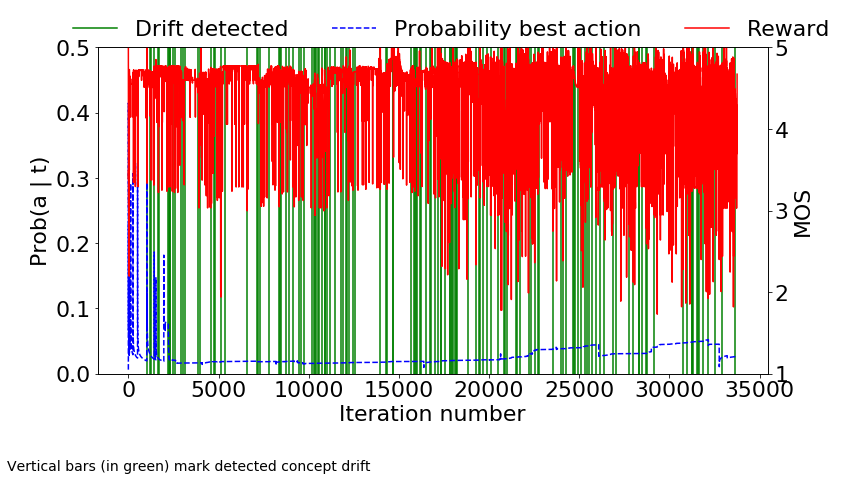

In [17]:
x = [v[0] for v in __iterations]
p1 = [v[5] / 100.0 for v in __iterations]
p2 = [v[7] / 100.0 for v in __iterations]

max_y = np.ceil(max(np.max(p1), np.max(p2)) * 10) / 10

fig = plt.figure()
ax1 = plt.gca()

plot_drifts(ax1, drifts_inGraph, max_y)
# plt.plot(x, p1, ":", label='Best estimated probability', color='red')  # ":"
plt.plot(x, p2, "--", label='Probability best action', color='blue')  # "--"
ax1.set_ylabel("Prob(a | t)")
ax1.set_xlabel("Iteration number")
# ax1.set_title("Probability of action and Reward")
ax1.set_ylim(0, max_y)


ax2 = ax1.twinx()
ax2.plot(x, __r, "-", label='Reward', color='red')  # ":"
ax2.set_ylabel("MOS")
ax2.set_ylim(1, 5)

#fig.legend(loc='upper left', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
fig.legend(loc=1, ncol=3, frameon=False)

_ = plt.text(0.02, -0.1, 'Vertical bars (in green) mark detected concept drift', fontsize=14, transform=plt.gcf().transFigure)

plt.savefig('Detection.pdf', quality=100, dpi=600, papertype='A4')